<a href="https://colab.research.google.com/github/PouriaRouzrokh/MIDeL/blob/main/chapters/9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/MIDeL/blob/main/chapters/9A.ipynb)

*Authors: Pouria Rouzrokh, MD, MPH, MHPE; Bardia Khosravi, MD, MPH, MHPE*

# Chapter 9: Training Strategies and Components


## Part 1: Introduction

So far, we have covered several essential topics you need for deep learning programming. We described what medical imaging data looks like and how we can build datasets and dataloaders using PyTorch and MONAI. We are now ready to train our first deep learning model!
We will do this by building a simple deep learning model and discussing the steps needed for classical PyTorch training. We will also introduce an easy way to apply deep learning models to unseen data (also known as inference) and validate their performance. Hopefully, you will be able to train a deep learning model of your own by the end of this chapter!

### Preparing the notebook


OK, let's begin by setting the environment for this notebook by installing MONAI.

In [1]:
# Installing required libraries
!pip install monai==1.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00


In [2]:
# Import the required python types for type hinting
# Turn off the notebook warnings

from typing import List, Tuple, Dict, Union, Callable, Iterable
import warnings
warnings.filterwarnings("ignore")

Next, we write a basic wrapper to make our code as deterministic as possible. As you probably know, deterministic programming will make most of our code generate the same outputs if it is run multiple times. In other words, random generators in a deterministic algorithm will create the same values every time they are called (which is why they are technically 'pseudorandom').

*   For more information about deterministic programming, read [here](https://www.geeksforgeeks.org/difference-between-deterministic-and-non-deterministic-algorithms/).  
*   For more information about wrappers in Python, read [here](https://www.geeksforgeeks.org/function-wrappers-in-python).

If you look at the next cell, you will find steps that set up Python, PyTorch, and MONAI to work in a deterministic way. However, making an algorithm deterministic is more complicated than it seems, especially when coding in Google Colab. Google Colab is set up to assign you an actual graphic processing unit (GPU) every time you start a new session. Unfortunately, there is currently no way to make this assignment deterministic to the best of our knowledge. If hardware like the GPU is changed (particularly to a different type of GPU), results may be different, even if you use wrappers like what have here.


In [3]:
# Set random seeds for deterministic programming

import torch
import os
import numpy as np
import monai
import random
from functools import wraps

def make_determinate(func):
  """
    Makes a wrapper (decorator) for other functions to determine a specific
    seed for Pytorch, Moani, and Numpy and enable deterministic programming.
  """
  @wraps(func)
  def wrapper(*args, **kwargs):
    if 'random_seed' in kwargs:
      random_seed = kwargs['random_seed']
    else:
      random_seed = 1000
    np.random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    monai.utils.misc.set_determinism(seed=random_seed)
    return func(*args, **kwargs)
  return wrapper

Next, let's check if a GPU is assigned to our session. Before running the following cell, make sure your Colab runtime is set to GPU. To do so, click on Runtime -> Change runtime type, and select GPU for the hardware accelerator.  

---

>
**Question**: Why do we need to connect to a GPU? The answer is that training deep learning models often involves running processes that are highly computational-dependent. Running these processes on central processing units (CPUs) one after the other will take a lot of time. However, GPUs can run the deep learning computations in parallel, significantly reducing the time needed for training.

---

In [4]:
# Selecting the processor device. Make sure your colab runtype is set to GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Checking the GPU device
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
NVIDIA A100-SXM4-40GB, 525.105.17, 40960 MiB


### Data collection

Now that the environment is ready, we need to download some data to work on. For this chapter and the next one, we will work with a public Chest X-Ray (CXR) dataset that contains images for normal and pneumonia patients. The original dataset is found [here](https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded), but we already moved that data to a Google Drive location to speed up the download process. That is the source from where you will download the data in the following cell.

In [5]:
# Downloading the original data from a shortened version of the following link:
# https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/
# f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded.

# Remove "sample data" folder that colab always includes but we don't need it!
# Please be careful with the "rm -rf" command. If you accidentally run it or change the
# location it is pointing towards, you may remove important files from your
# notebook.
!rm -rf ./sample_data/
import gdown

if not os.path.isdir('chest_xray'):
  gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1L8ox5fIwb_PijLcPEofQyhe3oGiYESO2",
        "chest_xray.zip",
        quiet=False
    )
  !unzip -q chest_xray.zip

  os.remove('chest_xray.zip')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1L8ox5fIwb_PijLcPEofQyhe3oGiYESO2
To: /content/chest_xray.zip
100%|██████████| 1.24G/1.24G [00:17<00:00, 71.4MB/s]


The above cell will download the data and put it in the disk space Google Colab provided for our notebook. Feel free to click on the "Files" icon on the left side of the screen and take a look at the downloaded files. These files were downloaded as a zipped folder, unzipped, and put in a folder called "chest_xray" (image below).

<br><img src="https://i.ibb.co/qMRQfzs/img1.png" alt="img1" border="0" height="300"><u><br><b>Figure 1.</b> Accessing the downloaded dataset using the File viewer in Google Colab.</u><br><br>

Now we can collect the paths to images available in this downloaded dataset. Fortunately, the original folder has the data split into training and test sets and also labeled based on their classes (i.e., normal vs. pneumonia). We will use the same data organization for the sake of this notebook. The following cell will save the paths to images into two different Python lists (one for the training set and one for the test set), along with their labels, either normal or pneumonia.

In [6]:
# Collecting all image paths, along with their associated labels and sets

def collect_imageinfo_list(images_dirpath: str) -> List:
  """
  Return a list of information tuples for all images, where each information
  tuple includes the associated path, label, and set for each image.
  Parameters:
    - images_dirpath (str): Path to the directory including all images.
    - imageinfo_list (List): a list of (file_path, file_label, file_set)
    for each image file.
  """
  imageinfo_list = list()
  for root, dirs, files in os.walk(images_dirpath):
    for file in files:
        if file.lower().endswith('.jpeg') or file.lower().endswith('.jpg'):
          file_path = os.path.join(root, file)
          dir_path = os.path.dirname(file_path)
          file_label = dir_path.split('/')[-1]
          file_set = os.path.dirname(dir_path).split('/')[-1]
          imageinfo_list.append((file_path, file_label, file_set))
  return imageinfo_list

imageinfo_list = collect_imageinfo_list('chest_xray')

train_imageinfo_list = [imageinfo for imageinfo in imageinfo_list
                        if imageinfo[2]=='train']
train_pneumonia_count = len([imageinfo for imageinfo in train_imageinfo_list
                             if imageinfo[1]=='PNEUMONIA'])
train_normal_count = len([imageinfo for imageinfo in train_imageinfo_list
                          if imageinfo[1]=='NORMAL'])
test_imageinfo_list = [imageinfo for imageinfo in imageinfo_list
                       if imageinfo[2]=='test']
test_pneumonia_count = len([imageinfo for imageinfo in test_imageinfo_list
                            if imageinfo[1]=='PNEUMONIA'])
test_normal_count = len([imageinfo for imageinfo in test_imageinfo_list
                         if imageinfo[1]=='NORMAL'])

print(f'Number of images in the training set: {len(train_imageinfo_list)} --> \
Pneumonia: {train_pneumonia_count} - Normal: {train_normal_count}')
print(f'Number of images in the test set: {len(test_imageinfo_list)} --> \
Pneumonia: {test_pneumonia_count} - Normal: {test_normal_count}')

Number of images in the training set: 5232 --> Pneumonia: 3883 - Normal: 1349
Number of images in the test set: 624 --> Pneumonia: 390 - Normal: 234


### Data investigation

It is always a good idea to look at your data before applying training, as there can often be 'surprises'. First, we can visualize some random images from the data to see how they look. The following cell will visualize nine random images and their associated labels.

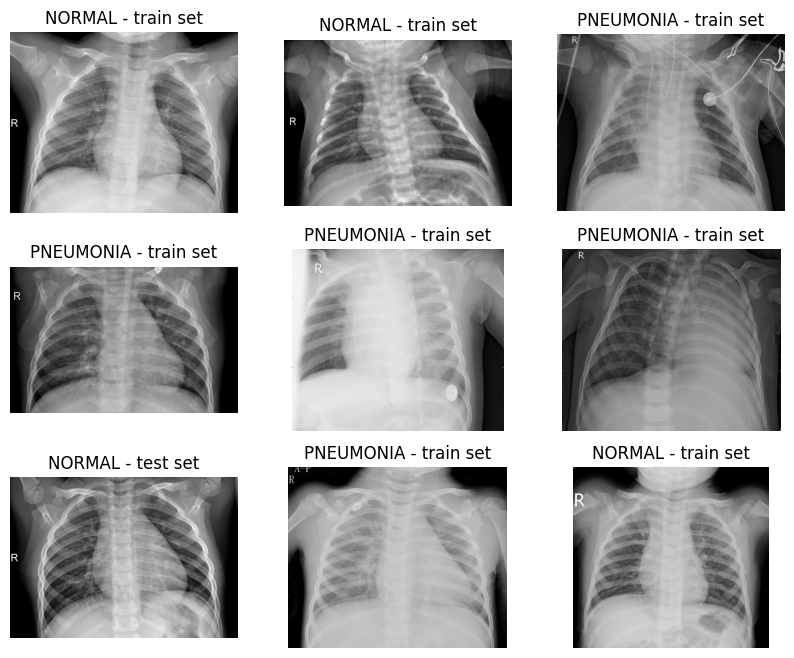

In [7]:
# Plotting sample images from the original data
import matplotlib.pyplot as plt
from skimage.io import imread

@make_determinate
def plot_sample_images():
  """
  Plot 9 sample images from the imaging dataset, while printing their
  associated labels and sets.
  """
  fig, axes = plt.subplots(3, 3, figsize=(10, 8))
  random_imagesinfo_items = random.choices(imageinfo_list, k=9)
  for i, imageinfo in enumerate(random_imagesinfo_items):
    image = imread(imageinfo[0])
    axes[i//3, i%3].imshow(image, cmap='gray')
    axes[i//3, i%3].axis('off')
    axes[i//3, i%3].set_title(f'{imageinfo[1]} - {imageinfo[2]} set')
  plt.show()

plot_sample_images()

Another routine step in exploring the data before proceeding to do any training is to investigate the size and dimension of images in our dataset. Before doing this, let's review what we mean by "size" and "dimension" from our previous chapters.

Suppose the NumPy array we load for an image has the shape of (400, 500, 3). In this example, the height (Y dimension) of the image is 400 pixels, the width (X dimension) of that would be 500 pixels, and the image has three channels, and in this case we have 3 because the image has been saved as RGB (Red, Green, Blue).

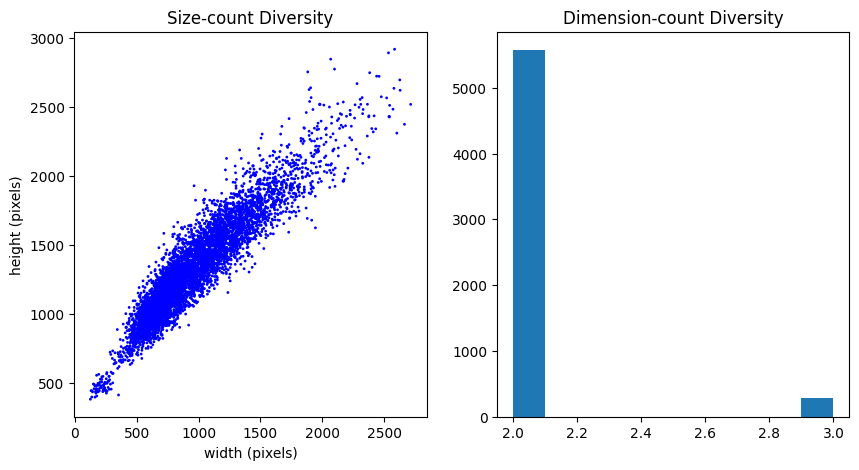

In [8]:
# Investigating the size of the images we have

def investigate_image_arrays():
  """
  Plot the size-count and dimension-count diversity plots for image arrays.
  """
  image_arrayshape_list = [imread(imageinfo[0]).shape
                           for imageinfo in imageinfo_list]
  image_size_list = [(shape[0], shape[1]) for shape in image_arrayshape_list]
  image_dimcount_list = [len(shape) for shape in image_arrayshape_list]
  image_size_set = set(image_size_list)
  unique_rows = [size[0] for size in image_size_set],
  unique_columns = [size[1] for size in image_size_set],
  unique_size_counts = [image_size_list.count(size) for size in image_size_set]
  # Plotting:
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].scatter(x=unique_rows, y=unique_columns,
                  s=unique_size_counts, c='blue')
  axes[0].set_title('Size-count Diversity')
  axes[0].set_xlabel('width (pixels)')
  axes[0].set_ylabel('height (pixels)')
  axes[1].hist(image_dimcount_list);
  axes[1].set_title('Dimension-count Diversity');

investigate_image_arrays()

As you can see, *nearly* all of the images are 2D (why do you think there are some 3D images as well?), but there is a tremendous range of image sizes in terms of pixels. Most AI networks requires images to have the same dimensions. That means we need to do some image processing to clean things up.

### Building datasets and data loaders

The following cell looks long, but you already know the steps it is doing. This cell loads our data into datasets and then builds dataloaders for our training and test data. As before, we use both PyTorch and MONAI in building these objects.

---

>
**Note**: Please refer to chapter 7 if you want to refresh your memory on how to build the datasets and data loaders.


---

In [9]:
# Building datasets and dataloaders using MONAI

from monai.transforms import (LoadImageD, EnsureChannelFirstD, ResizeD, Compose,
                              NormalizeIntensityD, RandRotateD, RandZoomD,
                              LambdaD, ToTensorD, RepeatChannelD,
                              Rotate90d, SelectItemsd)
from monai.data import Dataset
from torch.utils.data import DataLoader

@make_determinate
def build_dataloaders(train_imageinfo_list: List = train_imageinfo_list,
                      test_imageinfo_list: List = test_imageinfo_list,
                      image_size: int = 224,
                      augment_train_data: bool = False,
                      fct_to_train: float = 1.0,
                      fct_to_valid: float = 0.5) -> DataLoader:
  """
  Build and return train and test dataloaders.
  Parameters:
    - train_imageinfo_list (list): a list of (file_path, file_label, file_set)
    for each image file in the training set.
    - test_imageinfo_list (list): a list of (file_path, file_label, file_set)
    for each image file in the test set.
    - image_size (int): the output image size for the dataloader, which would be
    (image_size * image_size).
    - fct_to_train (float): fraction of training data to make available for
    building the training data loader.
    - fct_to_valid (float): fraction of the test data to use as the validation
    set (and not the test set).
    - train_loader (DataLoader): dataloader for the training set.
    - test_loader (DataLoader): dataloader for the test set.
  """
  def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

  label_dict = {'PNEUMONIA':1, 'NORMAL':0}
  train_data_list = [{'image': imageinfo[0], 'label':label_dict[imageinfo[1]]}
                     for imageinfo in train_imageinfo_list]
  test_data_list = [{'image': imageinfo[0], 'label':label_dict[imageinfo[1]]}
                    for imageinfo in test_imageinfo_list]

  # Shuffling the data before fractioning it
  # Note: We assume that each datapoint in the test_data_list belongs to
  # a seprate patient.
  random.shuffle(train_data_list)
  random.shuffle(test_data_list)

  # Using fractions of data
  P_train_list = [x for x in train_data_list if x['label']==1]
  N_train_list = [x for x in train_data_list if x['label']==0]
  P_test_list = [x for x in test_data_list if x['label']==1]
  N_test_list = [x for x in test_data_list if x['label']==0]
  touse_train_data = P_train_list[:int(len(P_train_list)*fct_to_train)] + \
  N_train_list[:int(len(N_train_list)*fct_to_train)]
  touse_valid_data = P_test_list[:int(len(P_test_list)*fct_to_valid)] + \
  N_test_list[:int(len(N_test_list)*fct_to_valid)]
  touse_test_data = [x for x in test_data_list if x not in touse_valid_data]

  # Building MONAI transforms
  Aug_transforms = Compose([
          LoadImageD(keys="image"),
          EnsureChannelFirstD(keys="image"),
          LambdaD(keys="image", func=lambda x: x[0, :, :].unsqueeze(0) if x.ndim==3 else x),
          ResizeD(keys="image", spatial_size=(image_size, image_size)),
          NormalizeIntensityD(keys="image"),
          RandRotateD(keys="image", mode="bilinear", range_x=0.26, prob=0.5),
          RandZoomD(keys="image", mode="bilinear"),
          Rotate90d(keys="image", k=3, spatial_axes=(0, 1)),
          ToTensorD(keys=["image", "label"]),
          RepeatChannelD(keys="image", repeats=3),
          SelectItemsd(keys=["image", "label"])
          ])
  NoAug_transforms = Compose([
          LoadImageD(keys="image"),
          EnsureChannelFirstD(keys="image"),
          LambdaD(keys="image", func=lambda x: x[0, :, :].unsqueeze(0) if x.ndim==3 else x),
          ResizeD(keys="image", spatial_size=(image_size, image_size)),
          NormalizeIntensityD(keys="image"),
          Rotate90d(keys="image", k=3, spatial_axes=(0, 1)),
          ToTensorD(keys=["image", "label"]),
          RepeatChannelD(keys="image", repeats=3),
          SelectItemsd(keys=["image", "label"])
          ])

  # Building MONAI datasets
  if augment_train_data:
    train_dataset = Dataset(touse_train_data, transform=Aug_transforms)
  else:
    train_dataset = Dataset(touse_train_data, transform=NoAug_transforms)
  valid_dataset = Dataset(touse_valid_data, transform=NoAug_transforms)
  test_dataset = Dataset(touse_test_data, transform=NoAug_transforms)

  # Building MONAI dataloaders
  train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,
                            num_workers=1,
                            worker_init_fn=worker_init_fn)
  valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False,
                            num_workers=1,
                            worker_init_fn=worker_init_fn)
  test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False,
                           num_workers=1,
                           worker_init_fn=worker_init_fn)
  return train_loader, valid_loader, test_loader

# Testing the shape and dtype for a sample batche from the training dataloader:

train_loader, valid_loader, test_loader = build_dataloaders()
sample_batch = next(iter((train_loader)))
print(f"batch['image'] shape: {sample_batch['image'].shape}")
print(f"batch['image'] dtype: {sample_batch['image'].dtype}")
print(f"batch['label'] shape: {sample_batch['label'].shape}")
print(f"batch['label'] dtype: {sample_batch['label'].dtype}")

batch['image'] shape: torch.Size([8, 3, 224, 224])
batch['image'] dtype: torch.float32
batch['label'] shape: torch.Size([8])
batch['label'] dtype: torch.int64


The above cell prints out the shape, dtype (data type) and labels of the images coming out of our data loaders. We can also proceed and visualize some examples of these images to ensure that we haven't messed them up:

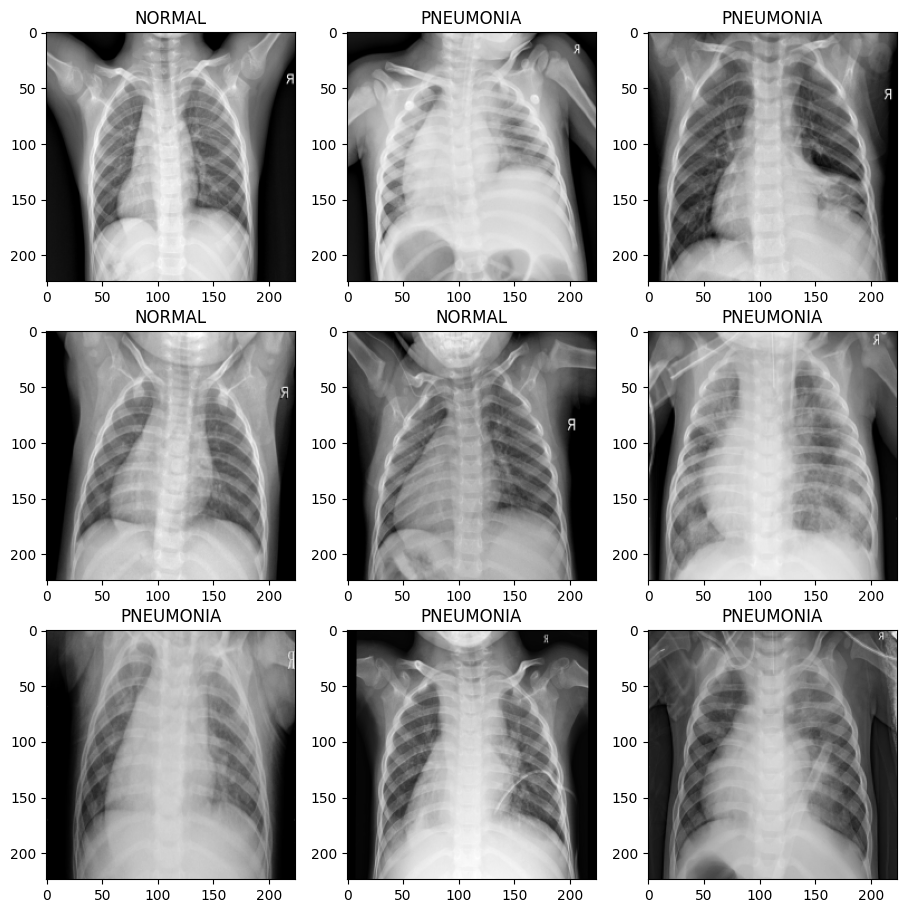

In [10]:
# Plotting sample images from the dataloaders.

@make_determinate
def plot_sample_dataloader_images(dataloader):
  """
  Plot 9 sample images from either the training or test dataloaders.
  """
  label_tensor_dict = {1:'PNEUMONIA', 0:'NORMAL'}
  dataiter = iter(dataloader)
  image_tensor_list = list()
  label_list = list()
  fig, axes = plt.subplots(3, 3, figsize=(11, 11))
  for i in range(9):
    data = next(dataiter)
    image_batch, label_batch = data['image'], data['label']
    axes[i//3, i%3].imshow(image_batch[0][0], cmap='gray')
    axes[i//3, i%3].set_title(label_tensor_dict[int(label_batch[0])])
  plt.show()

plot_sample_dataloader_images(train_loader)

As expected, the generated images from our dataloaders are now much more uniform. For example, all of them are resized to 224 by 224 pixels.
**Note that the images are now left-right flipped!!**


## Part 2: Big picture and concept defintions


### Neural networks as an equation

So far, we have built our data loaders and tested them to make sure they work. Another item we need before training is a deep learning model. You learned about deep learning models and their architectures in a previous chapter. You probably know that a deep learning model is actually an algorithm that looks like a very big mathematical equation. Let's pause for a moment and clarify what we mean by *mathematical equation*.
All mathematical equations, even as simple as an equation like $Y = aX + b$, have three components:

1.   one or multiple inputs ($X$ in the above equation).
2.   one or multiple parameters ($a$ and $b$ in the above equation).
3.   and one output ($Y$ in the above equation).

Suppose the parameters of the equation are already given. In that case, we can feed in some values for our input variables and receive their corresponding output. For example, if $a=2$ and $b=3$ in the above equation, and we supply $X=10$, then the output of the equation ($Y$) would be $2*10+3 = 23$.

A deep learning model or a neural network algorithm, regardless of how big or complicated it is, can be considered as an equation. The main difference is that the number of parameters and input variables in a neural network will be far more than our human minds can process or keep track of (typically in the millions)! Let's take a look at a simple three-layer neural network that takes three input variables ($X_1$, $X_2$, and $X_3$) and see how it can be regarded as a mathematical equation in the following figure:

<br><img src="https://i.ibb.co/hdQfRtm/img2.png" alt="img2" border="0" height="400"><u><br><b>Figure 2.</b> A three-layer neural network example.</u><br><br>

The neural network described above is a relatively simple mathematical equation with three inputs ($X_1$ to $X_3$), five intermediate values ($Y_1$ to $Y_5$), and one output ($Y_F$). It also has two distinct sets of parameters shown with the letters $w$ and $b$. As a neural network is usually an extension of linear equations, these parameters are called weights (shown by $w$), and those which do not are called biases (shown by $b$).  

You have probably seen more complicated neural network architectures than the one above. But, one point that this figure can help you better understand is what some of the frequently used terms in deep learning really mean in a mathematical context. For example, a "node" is a fancy name for intermediary outputs of each of the calculations happening within the equation ($Y_1$ to $Y_5$, and $Y_F$ are nodes), or arrows between the nodes show how some outputs of previous calculations are regarded as inputs for subsequent calculations. Likewise, a layer is a collection of nodes at the same level (i.e., they do not receive inputs or send outputs to each other).

However, deep neural networks are much bigger and more complicated than the three-layer network we presented above. Instead of three inputs, they usually receive hundreds to thousands or even millions of inputs. For example, a neural network that receives an image as its input actually regards every pixel value of that image as an input variable to its equation. Likewise, neural networks that work on text data regard each word in a given text as an input variable. The general principle, though, is still the same. A neural network is an equation that receives multiple inputs and generates an output that we desire to be meaningful (e.g., a correct prediction).  

‌Before proceeding, let's use some real numbers for the parameters and input variables and see how it looks. Lets suppose that our model receives three clinical input variables for patients with pneumonia and predicts their chance of living as the output. We can assume the input variables as follows:

* $X_1$: patient's sex (1 for females, 2 for males)
* $X_2$: patient's age divided by 100
* $X_3$: patient's white blood cell (WBC) count divided by 10,000

And we can assume that the output variable should always be between 0 and 1, where values closer to 1 mean a higher chance of survival. Using the sigmoid function as our activation function for the last layer, we can ensure that our model always generates a value between 0 and 1.



---


>
**Note 1**: all values and parameters in the following figure are imaginary and chosen randomly. It is also very unlikely that such a small model can really predict a pneumonia patient's prognosis. We just made up an example for you, so don't take it seriously!.

---
---


>
**Note 2**: we used the sigmoid function in all layers of this example network. However, many more alternative activation functions could be used instead of the sigmoid (at least for layers 1 and 2 that do not necessarily need to result in values between 0 and 1).


---

<br><img src="https://i.ibb.co/rtyCmCN/img3.png" alt="img3" border="0" height="400"><u><br><b>Figure 3.</b> A three-layer neural network example filled with random numbers.</u><br><br>

Now that we described how neural network equations can be useful in helping us solve real clinical problems, let's go back to our own example in this notebook and use it to explain the big picture of neural networks a little better.

Here, we are looking to build a neural network that will receive pixel values of a CXR as its inputs and then rely on its parameters to calculate a meaningful output for that specific CXR. For example, we may expect the output number `1` (or values close to 1) for CXRs with pneumonia and `0` (or values close to 0) for patients without pneumonia. This is similar to how equations work in the world of math. We provide inputs to them and they generate outputs for us. However, there are two apparent questions ahead of us if we want to achieve such a desired neural network:

1. What type of neural network (or equation) should we build? How many parameters should it have? How should those parameters be organized in different layers and nodes? How should we connect those components together? These questions can all be summarized in one technical domain of deep learning: "*architecture design*" for neural networks.


2. Even if we know the exact architecture needed for our neural network, how should we know the appropriate values for its parameters? In other words, we need to know the values of an equation's parameters before we can feed any input values to it and expect meaningful outputs. What we do to find the appropriate values for a neural network's parameters is called "*training*" of that neural network or deep learning model.

The following two sections will address each of the above questions.

### Neural network architecture designing

We previously tried to mathematically describe a simple example of deep learning models for you. Having such an equation-oriented model of neural networks in mind will help you better understand the many different architectures introduced across the literature for neural networks every day. Look at the following fantastic figure, for example.

<br><img src="https://i.ibb.co/JK0kDxP/img3.png" alt="img4" border="0" height="800"><u><br><b>Figure 4.</b> Variations of neural network architectures.</u><br>Source: https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464
</br><br><br>

Each node in this colorful diagram represents a different architecture. Putting their details aside, each has a different number of layers, nodes, connections, and activation functions. Imagine these components of deep learning models as Lego(TM) pieces that data scientists combine in unlimited ways to build their new toys, aka models, at the end. You might ask: how can I know which architecture works best for the problem I am working on?


---


>
**Note**: The words "model" and "network" are used interchangeably in this chapter.


---

Deep learning is not only a science but an art, and the above should help to explain why. You can look into the literature of deep learning (and you should) to see what others have used for problems that are similar to yours. Take note of scientific comparisons made to illustrate different architectures' strengths and weaknesses. But at the end of the day, there is rarely a clear rule for the correct architecture for a novel problem. It is your innovation, intuition, and art in combining the pieces available to you that determines how good or bad your final model will perform to address your problem of interest! On the same note, data scientists usually evaluate many different architectures for a specific problem to finally find the one that works best for them.

### Neural network training

Once we have selected the architecture for our neural network model, we still need to figure out what values to use for the model's parameters. In deep learning, this task is accomplished by looking at the available data (the training set) and "learning" the appropriate values for the parameters from that data.

Let us go back to our example once again. You saw before that all the CXRs we downloaded are already labeled; i.e., one or more radiologists have already labeled each as either 'normal' or 'pneumonia'. In other words, we have access to thousands of CXR examples (or input data to the model), in addition to their actual outcomes (or the ground truth *labels*), which a deep learning model should predict. The training task is to find the best set of parameters that will make our neural network predict (the mathematical output value) the closest outputs to the ground truth labels. This process happens iteratively and is called "model training ."

Recall again that we generally do not train on the entire available data set.
Instead, we first split it into training and validation sets (or sometimes, training, validation, and test sets). We then use the training set for training our model. We already did this splitting when making our data loaders (look above and remember how we built separate data loaders for different sets). Next, we build our initial deep learning model with random parameter values (later chapters will describe this 'initialization' in greater detail).

Of course, this initial model will not make any meaningful predictions for us, but as the training iterations go on, <u>the model will gradually change its parameter values to make better and better predictions. Such gradual improvement becomes possible by providing feedback to the model regarding its current parameters and performance, and more importantly, how their values should be changed to improve the predictions</u>. This feedback mechanism is the heart of model training, and we will discuss this further in Part 4.

In summary, we need to train our neural network on a portion of labeled data that we call the training set. The model will use this labeled data multiple times (each time is called an 'epoch') during the training and gradually change parameters to find their optimal values in order to minimize the predictions accross the training set labels. A model trained like this can then be used to make predictions on unseen (unlabeled) input data. Applying a trained model to unseen data is usually called "inference."

---

>**Note**: Most neural networks are trained on labeled training data, and this form of learning is referred to as "supervised learning." However, supervised learning is not the only approach to training models. Sometimes training is performed in unsupervised, semi-supervised, or self-supervised manners. In these variants, human-labeled training data is either unavailable to the model or is available differently compared to supervised learning. More on this in later chapters.

---

## Part 3: PyTorch models playground

With that as background, we are ready to start coding again. An excellent way to understand the training process is to compare a model's performance before and after training. This is what we will do in the current section.

### Creating a model

The following cell calls the `build_model` function, which we will use throughout this chapter for creating PyTorch models from scratch. Please note that this function will not train the model; we need to code for that separately.

The `build_model` function does two important tasks:

1.   It uses the torchvision library to create a model using the architecture the user requested: e.g., to build a ResNet50 model, we can code:
```python
from torchvision import models
model = models.resnet50()
```
or if you want to create a VGG16 model, you could type:
```python
model = models.vgg16()
```
Our code in the following cell does exactly the same thing in this line:
```python
arch = 'resnet'  ## Is this correct???   
pretrained = True
model = eval(f'models.{arch}(pretrained={pretrained})')
```
The only difference is that our code uses the Python "eval" command to build a model based on the value of the "arch" variable. This means that the function can build a ResNet or VGG-based model depending on the user's interest.<br>

  ---

    > **Note**: You may also note that we can pass a `pretrained` argument to the above command. We will introduce this argument and what it does in the last section of this notebook.

  ---
  Isn't it interesting that we loaded a relatively complicated model like ResNet50 or VGG16 in just one line of code? This is the magic of deep learning frameworks. Many of the complicated architectures are now available to developers in just one or two lines of code (1 line to 'import' them, and the other line to actually build the one you want). However, there are still occasions in real practice when developers need to develop their models from scratch or change a pre-loaded model.
  <br>

2.   When we build our models using PyTorch, they are almost always designed to throw out 1000 values (or, more accurately, a linear vector of size 1000) as their outputs. This is the case as many PyTorch default models were built to classify the images from the ImageNet dataset (which had 1000 classes). However, we only have two classes in our example for classifying CXRs. So, we should change the final layer of the model (also called the final fully connected layer, as it is not a convolutional layer) to have two output nodes instead of 1000. This will cause the model to create two values (or a vector of size 2) instead of 1000 values.
<br>

  ---

    > **Note**: Here we have specified 2 output classes, but above we said we would have a single output ranging from 0 to 1. A binary output (2 classes) is a special case where there is usually no effective difference and it is usually better to have fewer outputs. Why might we want to have 2 outputs rather than just 1?
  ---


In [11]:
# Building a resnet model

import torchvision.models as models
import torch.nn as nn
import shutil

@make_determinate
def build_model(arch: str = 'vgg16', pretrained: bool = False)-> Callable:
  """
  Build a resnet model using Pytorch.
  Parameters:
    - arch (str): baseline architecture of the model that could be called using
    torchvision.models.arch command.
    - pretrained (bool): whether or not to use pretrained weights.
    - model (Callable): built pytorch module.
  """

  # Loading a model with the user-specified architecture from torch
  if 'vgg' not in arch and 'alexnet' not in arch and 'resnet' not in arch:
    raise ValueError ('Only resnet, vgg or alexnet models can be loaded!')
  else:
    try:
      model = eval(f'models.{arch}(pretrained={pretrained})')
    except:
      raise ValueError ('The name of the architecture is not valid!')

  # Replacing the final fully conntected layer of the model
  # Please note that we have two classes, and therefore, the final FC layer
  # will have two final nodes
  # The VGG network has no FC layer, so we directly change its final layer
  if 'vgg' in arch or 'alexnet' in arch:
    model.classifier._modules['6'] = nn.Linear(4096, 2)
  else:
    num_in_features = model.fc.in_features
    model.fc = nn.Linear(num_in_features, 2)

  return model

Now that we have a model, lets see what its architecture looks like. For PyTorch models, we can use a library called `torchsummary` to see the layers of our model, the shape of each layer's output, and the number of parameters in each layer. Such a library is extremely useful if you are building your own model. For instance, it might help you detect that your model does not fit into your GPU's memory and you need to check what layer(s) are oversized.

It is very easy to use the torchvision library. You only need to use the "summary" command, and pass a PyTorch model and an input size to it. Please note that your PyTorch model should already be on GPU to work with this command hence we use the "to(device)" command to move our model to the GPU device that Google colab has assigned to us.

In [12]:
# Plotting the structure for a Vgg16 model

from torchsummary import summary
non_trained_vgg16 = build_model(arch='vgg16', pretrained=False).to(device)
summary(non_trained_vgg16, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Using a model for inference

Now you can do what you probably expected to do when you started this section. First, let's test our untrained model to see its baseline performance on differentiating between the normal and pneumonia CXRs. This is a good checkpoint for us to learn how to apply a PyTorch model for inference.

----
> **Note**: The code to use a Pytorch model for inference is the same for both trained and untrained models. So we can build an `evaluate_model` function that receives a model and a test data loader and then shows the model's performance on that test data loader. We can then use this function to evaluate the different models we will develop throughout this chapter.
---




In [13]:
# A function to evaluate a model's performance on the test_loader

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

@make_determinate
def evaluate_model(model: Callable,
                   test_loader: Iterable = test_loader,
                   plot_cm: bool = True) -> float:
  """
  Evaluate a given model's performance on the test set.
  Parameters:
    model (Callable): the pytorch model to be evaluated.
    test_loader (Iterable): test dataloader to be used as the test data.
    plot_cm (bool): whether or not to plot a confusion matrix.
    accuracy (float): accuracy of the model.
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  labels_list = list()
  preds_list = list()
  with torch.no_grad():
    for batch in tqdm(test_loader):
      inputs, labels = batch['image'].to(device), batch['label'].to(device)
      outputs = model(inputs)
      preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
      labels_list.append(labels)
      preds_list.append(preds)
    all_labels = torch.cat(labels_list).cpu()
    all_preds = torch.cat(preds_list).cpu()
    accuracy = (all_preds == all_labels).sum().item()/len(all_labels)

  if plot_cm:
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix - accuracy: {accuracy:.2f}')
    ax.xaxis.set_ticklabels(['Pneumonia', 'Normal']);
    ax.yaxis.set_ticklabels(['Pneumonia', 'Normal']);

  return accuracy

Please note a few things in the above function:

1.   Whenever we want to use a PyTorch model for inference, we first use the `model.eval()` command to put it in the evaluation mode. Conversely, when we want to train a PyTorch model, we put it in the training mode using the command `model.train()`. You will learn the difference between these two in the following section.

2.   When we iterate through the data from a PyTorch data loader, it returns a batch each time we call it (typically once in each loop of an iteration). Depending on how we specified the batch should be made, it may include different samples for a given batch, though all training samples should be returned over the course of a complete iteration (a.k.a. 'epoch'). Because we built our dataloaders using MONAI dictionary-type dataloaders, we can access the imaging data and labels of each batch using the `batch['image']` and `batch['label']` commands.

3.   Like the training, inference also runs faster on a GPU, so we send our images and labels data to GPU using the `to(device)` command. You don't need to change anything else in your code for running the commands on a GPU instead of a CPU, and that's a big benefit of PyTorch!

4.   Look at the following line of code and try to understand what it does:
```python
preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
```
If you remember, we assigned two nodes to the final layer of our model in one of the above cells. This means that the output of our model will naturally be a one-dimensional array (or a vector) with two values. These values look independent from each other at first, but we will use a trick during training and inference to make them meaningful. The trick is to use a mathematical function called `softmax` that receives an array of 2 or more input values and change them so that they sum up to 1. You can look at the following image and check its source page to better understand how softmax works:

  <br><img src="https://i.ibb.co/JCPxvzJ/img5.jpg" alt="img5" border="0" height="200"><u><br><b>Figure 5.</b> Softmax Activation Function Explained.</u><br>Source: https://towardsdatascience.com/softmax-activation-function-explained-a7e1bc3ad60
</br><br><br>

  Now, the two values of the final node will no longer be meaningless. The first value (the one in index 0 of the output array) denotes the probability that the input CXR is for a normal patient, and the second value (index 1 in the output array) denotes the probability that the CXR is for a patient with pneumonia. Well then, how should we say what the model's prediction is for that input CXR? The predicted class will be whichever class has a higher probability value. Therefore, we can use the `argmax` command to get that array index. The result of the "argmax" command and, therefore, the result of the previous code line is an array of zeros and ones, and the length of that array is our batch size. In other words, we now have the model's prediction for each input example in our batch.

5. Finally, please note that there are 2 outputs of our `evaluate_model`: First, the accuracy of the model, which we calculate by dividing the number of true predictions by the total number of predictions our model has made. The second is a performance table, also called a confusion matrix. It is easier to introduce this matrix when you are looking at it, so let's proceed and use this function to evaluate the performance of an untrained VGG16 function on our test data loader.

  0%|          | 0/39 [00:00<?, ?it/s]

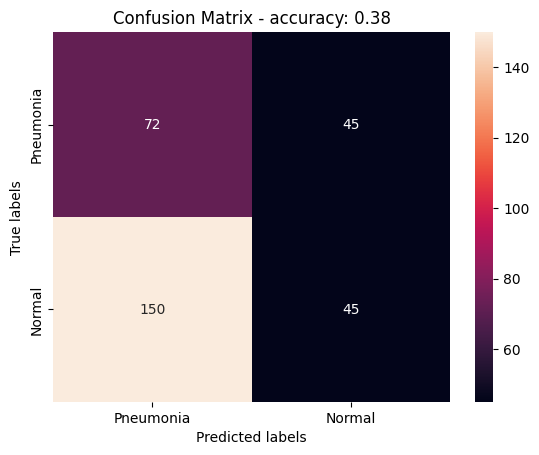

In [14]:
# Evaluating the performance of a non-trained model

_ = evaluate_model(non_trained_vgg16)

The figure above is a confusion matrix. It gets its name because it shows how many times the model confused one class of inputs with another (pneumonia versus normal in our case).
When we ran the above cell, our model had very poor performance, confusing many pneumonia and normal cases with each other. But don't be discouraged. Remember that we haven't trained it yet! In many cases, an untrained model will even classify all cases as one of the classes. In our scenario, for example, the model may predict 0 pnueomonia or 0 normal cases.
This might be a surprising result, but it can happen rather often when you use an untrained model for inference and if a class is very rare or very common. If accuracy is used as a metric, and some classes are rare, then the model can be very accurate by always saying it is not the rare class. However, we know that it does not mean the model is good.

---

> **Note**: Please note that your confusion matrix may be slightly different because the model's initial weights are random and they may be different from the initial weights for our model. However, the performance of this untrained model will almost always be very poor.

---

In this section, we learned how to create a PyTorch model using the already available architectures in torchvision library and use it for inference. We also observed that, as expected, an untrained model with random weights will perform very poorly in doing a task, including our task of classifying CXRs. This means we are ready to move to the next section, where we will train our models.

<br>**Coding Practice**: In the above code, we used a model for predicting the class of an entire batch. However (and in most real-world applications), we will need to use our model to infer from a single image. It should look trivial to you how to do that, but it is not a bad idea to practice it before we proceed. Look at the following code cell, where we have loaded a single CXR from our dataset as a NumPy array with shape (224 * 224 * 3). See if you can feed it to your model and get the predicted class for it by yourself. Of course, the predicted class may not be right as the model is untrained, but the goal is for you to practice inference with PyTorch models.

---

>**Hint**: This is what you need to do in order:
1.   Resize your NumPy array to the size (224 * 224).
2.   Convert your NumPy array to a PyTorch tensor.
3.   Add a channel dimension to your input tensor in dim=0 (i.e., your tensor should have the shape of (1 * 224 * 224) instead of (224 * 224)).
4.   Add a batch dimension to your input tensor in dim=0 (i.e., your tensor should have the shape of (1 * 1 * 224 * 224) instead of (1 * 224 * 224). This is necessary as PyTorch models expect their input data to have the batch format.
5. Use the "model(img_tensor)" command to get the model's output for the image and then apply "softmax" and "argmax" commands on the output to get the final prediction as we did above.

---

You may need to look at the previous chapters or search online a little to find out how to do the above steps, but that would be a fun and easy coding practice for you, so enjoy!




In [15]:
from skimage.io import imread

img_array = imread(train_imageinfo_list[0][0])
print(img_array.shape)

#### Type your code here:


####

(712, 1088)


## Part 4: Training implementation



We said before that training a neural network consists of letting the model make some predictions, then checking the gap between its predictions and the known values. The gap is the penalty, and that penalty drives changes in parameters so that the gap descreases as the training goes on. This cycle repeats many times, and the model will see each sample in the training data multiple times. Now, it is time to expand this initial explanation. Before we jump into PyTorch and work with our own scenario, it is not a bad idea to play with this concept with a much simpler dummy example.

### Training a simple model

Imagine we have numbers 0.01, 0.02, ..., up to 1 as our inputs, and a label for each input is defined based on the following formula: $y = x*0.2 + 0.06$ (e.g., if x is 0.3, then y will be 0.12):

In [16]:
input_tensor = torch.tensor(range(100)).float()/100
label_tensor = torch.tensor(list(map(lambda x:x*0.2+0.06, input_tensor)))

print(f'The first ten input values: {input_tensor[:10]}')
print(f'The first ten label values: {label_tensor[:10]}')

The first ten input values: tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900])
The first ten label values: tensor([0.0600, 0.0620, 0.0640, 0.0660, 0.0680, 0.0700, 0.0720, 0.0740, 0.0760,
        0.0780])


Now, let us say we want to train a very simple model (actually, a linear model with the general form y = ax+b) to learn to reproduce our data. In other words, we want our model to learn parameters a and b as 0.2 and 0.06, respectively. You perhaps remember that PyTorch models always start with random parameter values, and a model we create will not necessarily have our desired parameters. It could be any model like the following dummy_model we created using vanilla Python:

In [17]:
dummy_model = lambda x: x*0.01 + 0.04
output_tensor = torch.tensor(list(map(dummy_model, input_tensor)))
print(f'The first ten predicted values: {output_tensor[:10]}')

The first ten predicted values: tensor([0.0400, 0.0401, 0.0402, 0.0403, 0.0404, 0.0405, 0.0406, 0.0407, 0.0408,
        0.0409])


As you see above, the outputs the dummy model predicted are different from the actual labels. But how different are they? If we ultimately want to optimize the parameters of our model during training, the first step is to know how different the model's performance is versus what we expected. In the world of machine learning, the difference between the observed and expected performance of a model is called its "**loss**," and the function used to calculate that loss is called the "**loss function**." As you can imagine, we do not have a single loss or loss function for all machine learning problems in the world. As deep learning models are diverse, the loss functions to train them are diverse. Even for a single model, more than one loss function may be used.


---


>**Note**: The terms cost (cost function), loss (loss function), and criterion (criterion function) are often used interchangeably in machine learning. Also, the letter "*J*" is often used to describe the overall loss of a model.


---

Now, for the sake of our dummy example here, we are going to use a relatively simple but widely used loss function that is called the "**L2 loss**." This function is calculated given two input vectors y_true and y_predicted using the following formula:

<img src="https://i.ibb.co/hX9QVW8/img6.png" alt="img6" border="0"><br><u><b>Figure 6.</b> L2 Loss Function.</u>
<br>

It is called the L2 loss because the difference is squared (power of 2).  Can you guess what the name might be for a loss function where the difference is used (without squaring--power of 1)? Yes--it is the **L1 loss**. If you try to code this yourself beware of one thing: an error should always increase the loss, so you need to take the absolute value of the difference.


---

> **Note**: All loss functions in deep learning act on two input vectors: y_true and y_predicted. The reason is that regardless of what mathematical form those functions have, they all reflect the difference between the expected and observed outputs of the model.

---

The L2 loss is very easy to implement in PyTorch (remember **2 means power of 2 in Python):


In [18]:
dummy_loss_function = lambda labels, outputs: torch.sum((outputs-labels)**2)
loss = dummy_loss_function(label_tensor, output_tensor)
print(f'The current loss is: {loss}')

The current loss is: 1.6015435457229614


Now you might wonder what this value of loss means! Well, that is not an easy question to answer. Most of the time, loss values don't have a 'real world' meaning. What we care more about, though, is how the loss value changes when the model updates its parameters. The general assumption is that the closer the predicted and observed labels are, the lower the loss will be and vice versa. Feel free to change the code cell above and see how the loss will increase or decrease as you make your dummy model more or less different than the actual formula we used to create our data. You can also see that the L2Loss function will penalize outliers much more than an L1Loss function because of the squaring of the difference. If you REALLY wanted to penalize outliers, you could use higher powers.

<br>We can also use the matplotlib library to plot our expected and current models on a graph. As you see below, the orange line is our current model, and the blue line is what it should be, with the yellow area denoting their difference. Please note that this yellow area is not the L2 loss but is only a visual measure of the difference between the two lines.

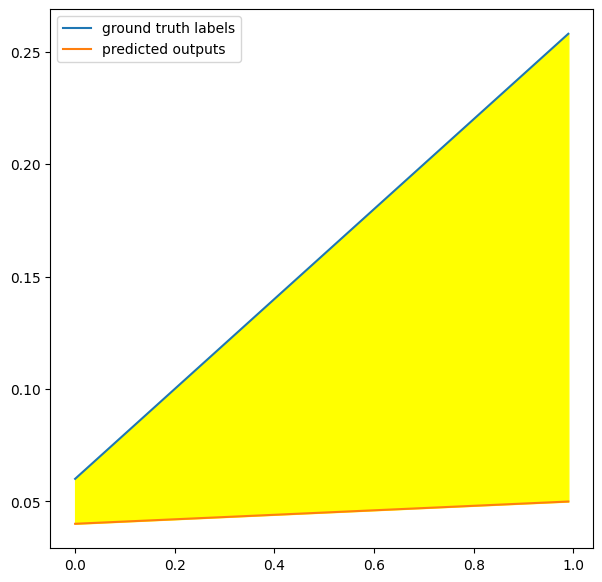

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(input_tensor, label_tensor, label='ground truth labels')
ax.plot(input_tensor, output_tensor, label='predicted outputs')
ax.fill_between(input_tensor, label_tensor, output_tensor, color='yellow')
ax.legend()
plt.show()

Now let's make things a little more serious. We are going to redefine our dummy model using PyTorch so that we are able to train it. Note that our model will be a simple linear model with one weight parameter and one bias parameter. After creating the model, we can immediately print the initial values PyTorch has randomly assigned for the weight and bias parameters of our model:

In [20]:
dummy_model = nn.Linear(1, 1, bias=True)
print(f"The weight for the current model is: {dummy_model.state_dict()['weight']}")
print(f"The bias for the current model is: {dummy_model.state_dict()['bias']}")

The weight for the current model is: tensor([[-0.1164]])
The bias for the current model is: tensor([-0.4839])


If we want to train our dummy model, we should also reformat our current data as PyTorch (or MONAI)-based datasets and dataloaders:

In [21]:
dummy_train_dataset = Dataset(
    [{'input': input_tensor[i], 'label': label_tensor[i]}
     for i in range(len(input_tensor))])
dummy_train_dataloader = DataLoader(dummy_train_dataset, batch_size=4)

# Check the dataloader
next(iter(dummy_train_dataloader))

{'input': tensor([0.0000, 0.0100, 0.0200, 0.0300]),
 'label': tensor([0.0600, 0.0620, 0.0640, 0.0660])}

Perfect!  Now we have our data, model, and loss function ready. Nevertheless, something is missing! Even if we know how much our model's observed and expected performance is different, how do we use this information to help the model improve its parameters?

<br> The answer to this question is the cornerstone of deep learning and is called: "**gradient descent**". Gradient descent consists of two main steps:

1.   In the first step, we calculate the gradients of the loss function with respect to each parameter (weight or bias) of the model. These gradients have valuable information. They tell us how the loss will change if we increase or decrease either of our parameters. For example, say d_w and d_b are the gradients ('derivatives' if you remember calculus, and hence the 'd_') of L2 loss with respect to the parameters of our dummy model. Suppose d_w is a positive number and d_b is a negative one. In that case, decreasing the w and increasing the b will both decrease the loss and therefore move our model one step closer to its desirable form. In more complicated models, where later layers of parameters are built upon earlier layers, the gradient of loss with respect to parameters in earlier layers is obtained by applying the chain rule of calculus to gradients obtained for the later layers. We recommend this blog post to become more familiar with what the chain rule is and how it helps in calculating the gradients in deep learning: [Deep learning and chain rule of calculus](https://medium.com/machine-learning-and-math/deep-learning-and-chain-rule-of-calculus-80896a1e91f9>)

2.   Knowing the gradients of loss with respect to parameters, we can update the parameters using the following formulas: <br><b><i>
new_parameter = old_parameter - d_parameter * learning rate <br></b></i>
where learning rate is a number denoting the pace of updating the model's parameters. More about learning rates later, but for now, you can just use the value '1' as the learning rate though in the real world it is much less than 1. This second step is called "**optimization**."

The above two steps happen in each **step** of model training, i.e., for each time the model goes through a batch of data. For each batch of data, the model predicts the label for each member of the batch, the loss is calculated by comparing the known and predicted labels, the gradients of the loss with respect to all model parameters are calculated, and finally, all parameters are updated using the gradient descent approach. The following figure shows how we change the values of a single weight parameter in a stepwise manner to redu e loss as much as possible:

<br><img src="https://i.ibb.co/xXH6pDs/img7.png" alt="img7" border="0" height="300"><u><br><b>Figure 7.</b> Illustration of gradient descent for a single parameter.</u><br>Source: https://www.ibm.com/cloud/learn/gradient-descent
</br><br><br>


---


>**Note**: A "**step**" in model training denotes each checkpoint when the model has seen a single *batch* of data. On the other hand, an "**epoch**" denotes when the model has seen the entire training data set once. Therefore, an epoch consists of (number of data points / batch size) steps. Actual training sessions often have 10's to 100's of epochs.


---

It is worth pausing here to reflect on the process we described above.

First, note how the gradient descent process is simple in concept but complex in practice. Unlike our dummy model, which only has two parameters, actual deep learning models have millions of parameters, and updating each of those in each step is not something any human mind can or even regular CPUs can do efficiently. We almost always rely on the parallel computation capacity of powerful GPUs to train the model.  

Second, note that selecting an appropriate learning rate is critical for training a deep learning model. Like the [story of Goldilocks and the 3 Bears](https://americanliterature.com/childrens-stories/goldilocks-and-the-three-bears), it is critical that it be 'just right'. A learning rate that is too small will hinder the pace of parameter updates, but if too large, it will cause the loss to oscillate and prevent the weight from finding its optimal value or converging to a global minimum as described below:

<br><img src="https://i.ibb.co/MGxgs57/img8.png" alt="img8" border="0" height="400"><u><br><b>Figure 8.</b> Small and large learning rates.</u><br>Source: https://www.ibm.com/cloud/learn/gradient-descent
</br><br>

Furthermore, the loss landscape for a single parameter is not always as straightforward as in the above plots. The gradients for a single parameter may become zero (so that the loss curve forms a saddle point") or change direction during the training and form what is called a "local minimum." If the gradient is 0, the parameters will not be altered. Even more insidious are local minima where the loss will falsely look like it has the least (best) value. It is important that we not stop our search in such a local minimum, and that we continue on to look for the "global minimum", where the loss really has its lowest value. Things are more complicated when you think that we have millions of parameters, and the loss landscape is many dimensions versus the 2D curves we show below:

<br><img src="https://i.ibb.co/fFL9P9C/Fig9.png" alt="Fig9" border="0" height="400"><u><br><b>Figure 9.</b> Local minimum and saddle points.</u><br>Source: https://www.ibm.com/cloud/learn/gradient-descent
</br><br>

Considering these challenges, do we have any tools to control and optimize the gradient descent during training? The answer is 'yes'. Here are a few tools available to data scientists:

<br>**Tool 1 - Learning Rate Schedules**:
As we said above, selecting a reasonable learning rate is core to smooth training. In simple deep learning training sessions, like in this chapter, the learning rate is constant during the entire training. However, there are ways to alter the learning rate during the training or even give it a 'schedule' to change constantly in a way you desire. Data scientists usually use learning rate schedulers to overcome problems like local minima or the problem of vanishing or exploding gradients.

---

> **Note 1**: **Vanishing Gradients** is the term used to describe when the loss gradient with respect to a parameter gets very close to zero. Conversely, **Exploding gradients**, occur when the gradients become very large. Either way, this gradient can be multiplied by other gradients during the chain rule calculations making the resulting updates either zero (no update) or very large, in which case they dominate all the other parameters. Both cases can lead to poor training. Therefore, we always prefer to prevent our gradients from getting too small or too large during the training. We will describe how to do this later on.

---
---

>**Note 2**: When training a deep learning model, there are many value choices we need to make that are different from parameters. Unlike model parameters that are learned, there are no simple ways to learn these values. Examples include the learning rate (and any scheduling), the number of epochs over which you train your model, and the batch size. Such values are called "hyperparameters," and the process of finding the best hyperparameters for each training is called "hyperparameter tuning." Like selecting the best architecture for your model, finding the best set of hyperparameters is a matter of experimenting and using general intuition, science, and the art of data science!

---


<br>

**Tool 2 - Loss Curves**:
Another helpful tool to understand the course of optimization is a plot of the loss value for each training epoch, known as a 'loss curve'. Unlike the above figures, which illustrate the change in loss landscape with respect to a single parameter, a loss curve plots the overall loss of the model for each epoch. Put another way, the loss curve shows how the loss is changing during the training. If the model is learning efficiently, the loss curve will tend to descend  during a training session (although oscillations could be normal). As shown in the figure below, we almost always plot two loss curves for the model. One (shown in blue) is the loss of the model computed on the training data and the other line (shown in orange) is the loss computed for the validation data. The comparison of these two curves during training gives valuable information to the data scientists regarding their models and how well it is learning the task versus learning the training data set (overfitting).

<br><img src="https://i.ibb.co/LhjjxZs/img10.png" alt="img10" border="0" height="300"><u><br><b>Figure 10.</b> Example of training and validation loss curves</u><br>Source: https://bit.ly/3tYfWXF
</br><br>

**Tool 3 - Optimizer Algorithms**:
Gradient descent has been very influential in the history of deep learning but is nowadays one of the simplest algorithms we can use to optimize our model's parameters. Many more algorithms are available that change the parameters more effectively. These new optimizers are more resistant to problems like vanishing and exploding gradients. As discussed later in this chapter, they help avoid overfitting or underfitting.

Optimization is a complicated process, and deep learning frameworks like PyTorch have made the work of developers much easier by creating optimizer classes. These classes will take care of the entire optimization calculations for us! For example, below we show how to create a simple stochastic gradient descent optimizer in PyTorch that we will apply to our dummy training. We only need to pass a learning rate and model parameters to the torch.optim.SGD class and PyTorch will create an optimizer instance from that class for us in a single line of code:

In [22]:
dummy_optimizer = torch.optim.SGD(dummy_model.parameters(), lr=0.005)

Perfect! Now we have our data, loss, and optimizer. With all these in hand, we are ready to train a model in PyTorch. We only need to run the few lines of code per step of training (i.e., per each batch of data that the model sees):


```python
# Get the training inputs and labels from the training dataloader.
# Prepare your loss function and optimizer.

model.train()                                       #Line 1          
optimizer.zero_grad()                               #Line 2
train_outputs = model(train_inputs)                 #Line 3
loss = loss_function(train_labels, train_outputs)   #Line 4
loss.backward()                                     #Line 5
optimizer.step()                                    #Line 6


# Log the training loss at the end of each step, if needed.
# Using loss.item() will return its raw value as a standard Python number and with no gradients attached to it.
```



Let us go through the above six lines:

*   Line 1: As mentioned before, each PyTorch model can be either in training or evaluation mode. When in the training mode, PyTorch will keep track of the gradients of the model's parameters. This is required for training.<br><br>
*   Line 2: This line makes sure our optimizer has no memory of the gradients that happened in the last step. It resets the optimizer, making it ready for the new optimization.<br><br>
*   Line 3: You already know this line: it feeds the inputs to the model to obtain its predicted outputs. From a training prespective, this step is usually called the "**forward propagation**" or the "**forward pass**"<br><br>
*   Line 4: You also know this line. The loss is calculated using the loss function we defined before.<br><br>
*   Line 5: Calling the backward method on loss will cause PyTorch to collect the gradients of loss with respect to every single parameter in the model (unless the requires_grad=False for a parameter, which is a way of freezing some parameters--we will describe this later). These gradients are then stored in the x.grad attribute of each parameter x. So, the model itself preserves the last gradients of loss with respect to its parameters. This step is usually called the "**backpropagation**" or the "**backward pass**".<br><br>
*   Line 6: And finally, the 'learning' happens here. Calling the step method of an optimizer will do the optimization operation and update all the parameters based on their gradients, the learning rate, and the optimizer.

---


>**A note on training vs. validation loops:**<br>
As we mentioned before, the above lines of code are executed for each training step. This means these lines are executed within two inner "for" loops! The first loop iterates through the number of epochs we use for training. The second loop iterates through our training data loader, so we loop once for each batch produced. This inner loop is called the training loop. When the model sees all batches, the inner loop ends, and the outer loop goes on to the next epoch. This will restart a new training loop, and this cycle goes on until the last epoch. <br><br>
In almost all standard deep learning training sessions, there is a validation loop following the training loop. The validation loop also runs within the epoch loop (i.e., it is run every epoch). However, it is distinct from the training loop. In the validation loop, the model iterates through the validation data loader (not the training data loader), and the model is in the evaluation mode. Although the loss is still calculated in each step, no backward pass and optimization happen based on the validation data. The reason is we want to use the validation data to evaluate our model, not for training it. This is an important point: models should never 'see' (i.e., be trained on) validation data during their training session. Failing to do this will result in models that look to be working very well but that may perform very poorly on a fair and real-world evaluation!


---

<br>

The below lines of code are the validation loop of a model. Please note the differences between this code block and the one above for the training loop:

```python
# Get the validation inputs and labels from the validation dataloader.

model.eval()                                                 
valid_outputs = model(valid_inputs)                       
loss = loss_function(valid_labels, valid outputs)       

# Log the validation loss at the end of each epoch, if needed.
```

In summary, the following schematic figure demonstrates how training and validation loops are organized within an epoch loop:

<br><img src="https://i.ibb.co/w4RJgBD/img11.png" alt="img11" border="0" height="500"><u><br><b>Figure 11.</b> Schematic shape of training and validation loops</u><br><br>


It is important that you now reflect on what you have learned as it is the basis for all things going forward. If you feel ready, it is time to show you how this process works in action. The following code will train our dummy model to learn the data we have. Please note that:
*  As this model has only two parameters, we train it on a CPU.
*  We log the epoch number, the raw value of the loss, and the output tensors of the model at the end of each epoch. Before logging, we put the model in the evaluation mode to not accidentally change each parameter's gradients anymore.
*  For simplicity, we do not use any validation loop in this training. We will do that in our main training for the CXR classifer.


In [23]:
max_epochs = 50
epoch_log_list = list()
for epoch in tqdm(range(max_epochs)):
  dummy_model.train()
  for i, batch_data in enumerate(dummy_train_dataloader):
    inputs = batch_data['input'].reshape(4, 1)
    labels = batch_data['label'].reshape(4, 1)
    dummy_optimizer.zero_grad()
    outputs = dummy_model(inputs)
    loss = dummy_loss_function(labels, outputs)
    loss.backward()
    dummy_optimizer.step()
  dummy_model.eval()
  output_tensor = dummy_model(input_tensor.reshape(100, 1)).detach().flatten()
  epoch_log_list.append([epoch, loss.item(), output_tensor])

  0%|          | 0/50 [00:00<?, ?it/s]

Now that the training is over, let us visualize the saved model for some epochs (in orange) compared to the expected ground truth model (in blue). These comparisons will help us better understand the training and how the model was improved during each epoch:

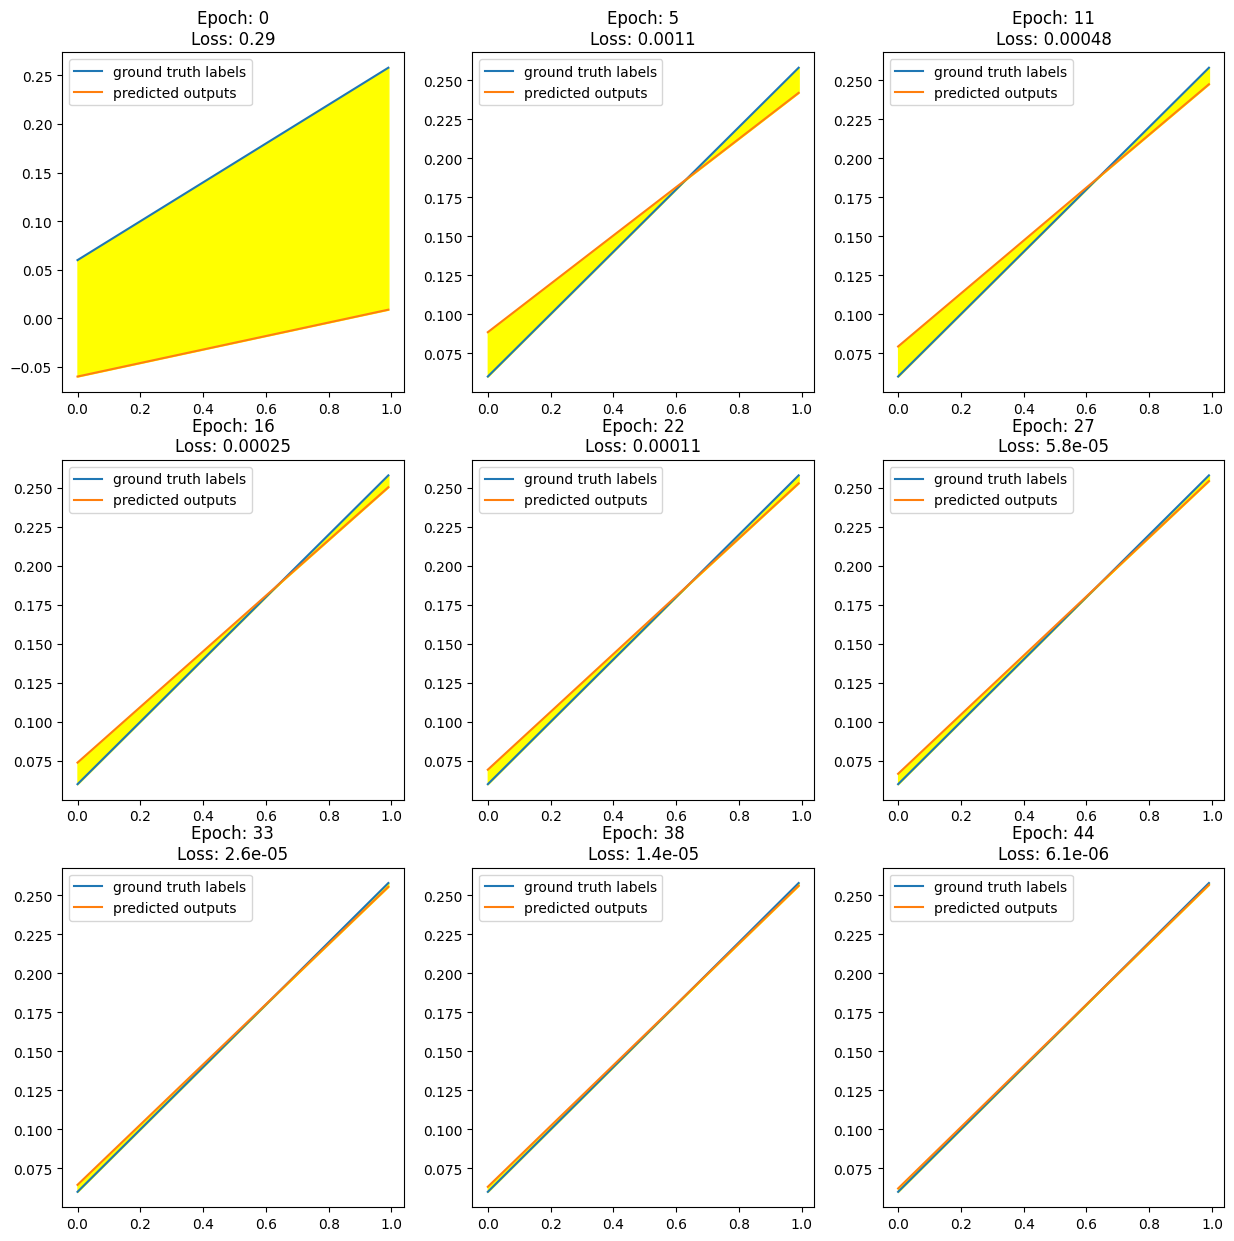

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(9):
  index = i*max_epochs//9
  ax = axes[i//3, i%3]
  epoch, loss, output_tensor = epoch_log_list[index]
  ax.plot(input_tensor, label_tensor, label='ground truth labels')
  ax.plot(input_tensor, output_tensor, label='predicted outputs')
  ax.fill_between(input_tensor, label_tensor, output_tensor, color='yellow')
  ax.set_title(f"Epoch: {epoch}\nLoss: {loss:.2}")
  ax.legend()
plt.show()

As you see above, our model gradually learned to simulate the ground truth model we used to generate our data. If you print the parameters of the final model, they should be close to the orignal *w* (0.2) and *b* (0.06) we chose for our ground truth model:

In [25]:
print(f"The final model's weight is: {dummy_model.weight.item():.3}")
print(f"The final model's bias is: {dummy_model.bias.item():.3}")

The final model's weight is: 0.198
The final model's bias is: 0.0616


Wow, these numbers are very close to the target values. Of course, our dummy problem was not difficult, but anyways, seeing a model training well is always exciting! We can also plot the loss curve for the model to see how it decreased throughout the training:

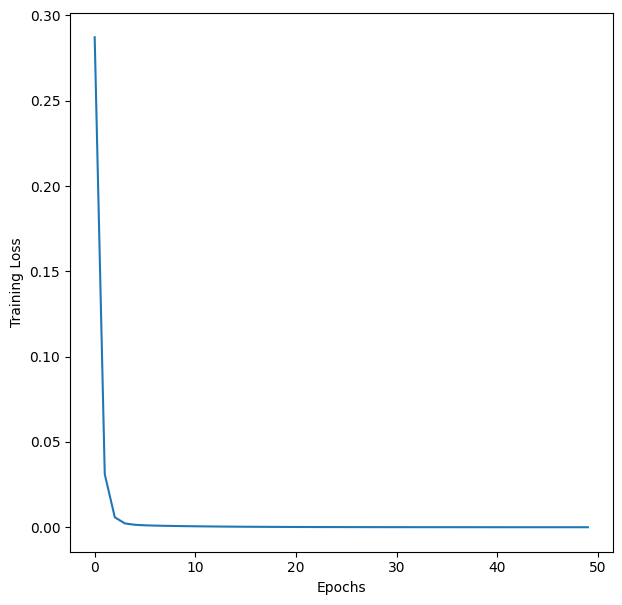

In [26]:
loss_values = [x[1] for x in epoch_log_list]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(loss_values)
ax.set_xlabel('Epochs');
ax.set_ylabel('Training Loss');
plt.show()

Awesome! After this successful dummy training, we can now go back to our CXR classifier and apply the same principles for training that model.

### Training a CXR classifier

We have already prepared the data loaders and the model for training our CXR classifier. The training loop we will use will also be very similar to the dummy model we trained above, with a few differences:

1.   We will use a new loss function called **"binary cross-entropy (BCE)"** instead of the L2 loss. This loss function is suitable for binary classification scenarios like ours, where the model's output is dichotomous. For example, in our case, each CXR should be classified as "normal" or "pneumonia". The formula for the BCE loss is as follows:
<br><img src="https://i.ibb.co/thMdMzP/img12.png" alt="img12" border="0"><u><br><b>Figure 12.</b> Binary cross-entropy loss function</u><br>
where $N$ is the total number of samples, *$y_{i}$* is the true label for the "$i$"th sample, and *p(*$y_{i}$*)* is the model's prediction for that sample. Cross-entropy measures the relative entropy between two probability distributions over the same set of events. So, $H_{p}(q)$ means to calculate cross-entropy between the real data distribution $q$ and the predicted label distribution $p$. The distribution $q$ is simply calculated using probability weights from the distribution $p$. For example, if the true label for a given CXR is normal, and the value of the model's final prediction (after applying the softmax function) for the CXR is 0.3 probability for normal and 0.7 probability for pneumonia, then *p($y_{i}$)*=0.3 (i.e., the predicted probability for the true label is 0.3). The BCE (and its more generalized form, the categorical cross-entropy) are widely used loss functions for classification problems. Although we cannot discuss the math behind these formulas in detail, you can check the following blog post to learn more about them: [Understanding binary cross-entropy / log loss: a visual explanation](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)
<br><br>
2.   As opposed to our dummy example, we will have both training and validation loops here. For each of these loops, we will log the loss value and the value of our accuracy metric.

  ----

  >**Note on the difference between performance metrics and loss functions**:<br> When using both the BCE loss and the accuracy metric, two questions may come to mind: First, why do we not use the BCE value as our metric? And second, why do we not use accuracy as our loss function? The answer to the first question is that the output of the accuracy formula is usually more understandable (or tangible) to data scientists compared to BCE loss values. For the second question, not all metrics can be used as loss functions. Although accuracy is a very interpretable metric, its formula is not differentiable. This means we cannot calculate the gradients of that formula with respect to the model's parameters. In summary, not all metrics are appropriate as loss functions, and not all loss functions are appropriate as performance metrics. However, depending on the problem, sometimes these two may be similar.

  ---
<br>

3.   Another new thing we do in this training is to save our best performing model during the training. If we do not save our model during training, it will be lost. The process of saving a model during the training is a simple form of "model selection." Model selection can be made using many criteria. Here, we follow the most common approach, which is to save the model with the lowest (best) **validation** loss.<br><br>

4. Finally, we will run this training on our GPU, since working with images take much more memory and is not efficient on CPUs (it will take 10s-1000s of times longer depending on CPU and GPU).


With the above points in mind, please take a look at the following code cell which provides a function to train our CXR classifier. Please note that this function receives our model, data loaders, loss function (here called criterion), and optimizer as inputs. We should also give it the desired name for saving the model and the maximum number of epochs we want to use to train the model. This function will be used many times but with different parameters in next sections of this chapter.


In [27]:
def train_classifier(model: torch.nn.Module,
                     model_name: str,
                     train_loader: Iterable,
                     valid_loader: Iterable,
                     criterion: Callable,
                     optimizer: torch.optim,
                     num_epochs: int,
                     plot_curves: bool):
  """
  Train a classifier model using pytorch and the given parameters.
  Parameters:
    model (Callable): any pytorch module,
    model_name (str): name of the model to be saved.
    train_loader (Iterable): dataloader for training data,
    valid_loader (Iterable): dataloader for validation data,
    criterion (Callable): any loss function,
    optimizer (torch.optim): a pytorch optimizer,
    num_epochs (int): number of epochs to train the model,
    plot_charts (bool): whether or not to plot the training and validation loss
    and accuracy curves.
  """

  # Sending the model to device (preferably GPU)
  model.to(device)

  # Releaseing the GPU memory. This is not necessary, but a good practice to do
  # before starting new training sessions.
  with torch.no_grad():
    torch.cuda.empty_cache()

  # Building a saving directory for models
  model_save_dir = os.path.join('Best_Models', model_name)
  if os.path.exists(model_save_dir):
    shutil.rmtree(model_save_dir)
  os.makedirs(model_save_dir, exist_ok=True)

  # lists to log the epoch values
  epoch_train_loss_list = list()
  epoch_train_accuracy_list = list()
  epoch_valid_loss_list = list()
  epoch_valid_accuracy_list = list()

  # Starting the training loop
  for epoch in range(1, num_epochs+1):
    print("-" * 20, f'\nStarting epoch: {epoch}/{num_epochs}')

    ## training
    model.train()
    steps_train_loss = 0.0
    steps_correct_predictions = 0

    for batch in tqdm(train_loader, unit="batch"):
      inputs, labels = batch['image'].to(device), batch['label'].to(device)
      ### Zero the parameter gradients
      optimizer.zero_grad()

      ### Forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      ### Accumulating the loss and number of correct predictions in step
      steps_train_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      steps_correct_predictions += (predicted == labels).sum().item()

    ## Measuring the epoch training loss and accuracy
    epoch_train_loss = steps_train_loss/ len(train_loader)
    epoch_train_loss_list.append(epoch_train_loss)
    epoch_train_accuracy = steps_correct_predictions / len(train_loader.dataset)
    epoch_train_accuracy_list.append(epoch_train_accuracy)

    ## validation
    model.eval()
    steps_valid_loss = 0.0
    steps_correct_predictions = 0

    for batch in tqdm(valid_loader, unit="batch"):
      inputs, labels = batch['image'].to(device), batch['label'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      ### Accumulating the loss and number of correct predictions in step
      steps_valid_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      steps_correct_predictions += (predicted == labels).sum().item()

    ## Measuring the epoch validation loss and accuracy
    epoch_valid_loss = steps_valid_loss/ len(valid_loader)
    epoch_valid_loss_list.append(epoch_valid_loss)
    epoch_valid_accuracy = steps_correct_predictions / len(valid_loader.dataset)
    epoch_valid_accuracy_list.append(epoch_valid_accuracy)

    ## Printing the logs
    print(f'train loss: {epoch_train_loss:.2f} | \
    train accuracy: {epoch_train_accuracy:.2f}')
    print(f'valid loss: {epoch_valid_loss:.2f} | \
    valid accuracy: {epoch_valid_accuracy:.2f}')

    ## Saving the best model
    if epoch==1:
      best_valid_loss = epoch_valid_loss
      weight_name = f'{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth'
      torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
    elif epoch_valid_loss < best_valid_loss:
      weight_name = f'{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth'
      torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
      best_valid_loss = epoch_valid_loss

  # Printing the best model
  print(f'\nTrainng was over. The best model was: {weight_name}')

  # Plotting the loss and accuracy curves
  if plot_curves:
    epoch_train_loss_list.insert(0, 0)
    epoch_train_accuracy_list.insert(0, 0)
    epoch_valid_loss_list.insert(0, 0)
    epoch_valid_accuracy_list.insert(0, 0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(epoch_train_loss_list, color='blue', label='training')
    axes[0].plot(epoch_valid_loss_list, color='orange', label='validation')
    axes[0].set_xlim(1, len(epoch_valid_loss_list)+1)
    axes[0].set_title('Loss curves')
    axes[0].legend()
    axes[1].plot(epoch_train_accuracy_list, color='blue', label='training')
    axes[1].plot(epoch_valid_accuracy_list, color='orange', label='validation')
    axes[1].set_xlim(1, len(epoch_train_accuracy_list)+1)
    axes[1].set_title('Accuracy curves')
    axes[1].legend();

  # Loading the best weights and returning the model
  model.load_state_dict(torch.load(os.path.join(model_save_dir, weight_name)))
  return model

Alright, now let's proceed to our first training and see the performance of our trained model in action. For this initial training, we will use a VGG16 architecture for the model and let it train for 10 epochs. Please note that each epoch will take a few minutes to run (depending on your GPU), so grab your cup of coffee and give yourself a little break!

-------------------- 
Starting epoch: 1/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.34 |     train accuracy: 0.86
valid loss: 0.63 |     valid accuracy: 0.75
-------------------- 
Starting epoch: 2/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.15 |     train accuracy: 0.94
valid loss: 0.56 |     valid accuracy: 0.79
-------------------- 
Starting epoch: 3/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.11 |     train accuracy: 0.96
valid loss: 0.66 |     valid accuracy: 0.78
-------------------- 
Starting epoch: 4/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.09 |     train accuracy: 0.97
valid loss: 1.13 |     valid accuracy: 0.74
-------------------- 
Starting epoch: 5/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.07 |     train accuracy: 0.97
valid loss: 0.72 |     valid accuracy: 0.80
-------------------- 
Starting epoch: 6/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.06 |     train accuracy: 0.98
valid loss: 2.58 |     valid accuracy: 0.72
-------------------- 
Starting epoch: 7/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.05 |     train accuracy: 0.98
valid loss: 1.65 |     valid accuracy: 0.71
-------------------- 
Starting epoch: 8/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.04 |     train accuracy: 0.98
valid loss: 1.73 |     valid accuracy: 0.71
-------------------- 
Starting epoch: 9/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.04 |     train accuracy: 0.99
valid loss: 1.25 |     valid accuracy: 0.76
-------------------- 
Starting epoch: 10/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.03 |     train accuracy: 0.99
valid loss: 1.49 |     valid accuracy: 0.74

Trainng was over. The best model was: vgg16_model_1_Epoch2_ACC=0.7916666666666666.pth


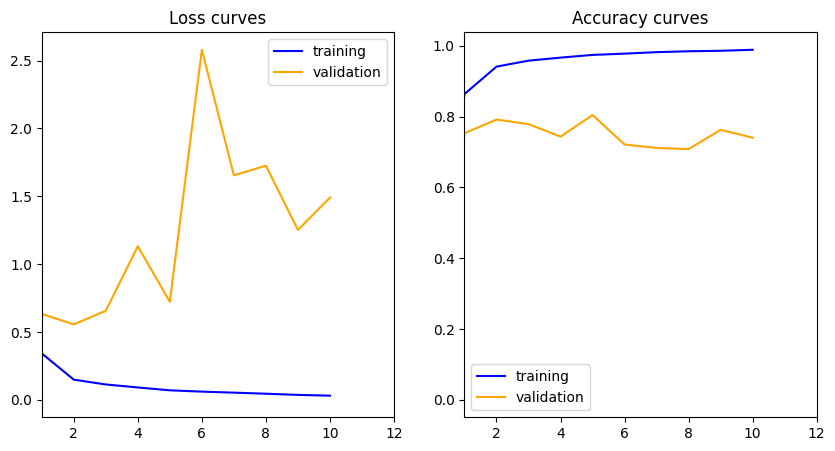

In [28]:
# Doing a base-line training with a non-trained and not-pretrained model
#  You may need to vertically scroll within the code output window
# in order to see all of the output.

vgg16_model_1 = build_model(arch='vgg16', pretrained=False)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(vgg16_model_1.parameters(), lr=learning_rate)
num_epochs = 10
vgg16_model_1 = train_classifier(model=vgg16_model_1,
                                 model_name='vgg16_model_1',
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 num_epochs=num_epochs,
                                 plot_curves=True)

  0%|          | 0/39 [00:00<?, ?it/s]

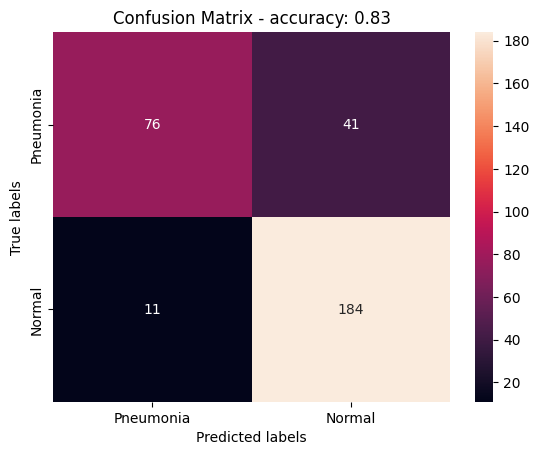

In [29]:
# Evaluating the performance of vgg16_model_1 on the test set

_ = evaluate_model(vgg16_model_1)

First look at the loss and accuracy curves. Can you see where overfitting has started? What do you think is the reason for those oscillations in the loss curves?

Now look at the confusion matrix. How do you interpret that? Does our model have a more challenging job detecting the pneumonia cases or the normal cases?

## Part 5: The concept of fit

You have previously learned the definition of fit, overfitting, and underfitting. As a quick review, whenever we train a regression model, we are trying to find a curve in a multidimensional space where most of our data points fall on or very close to this curve. Speaking more simply, a fit model is nothing different from a well-trained model. Unlike a well-fit (or well-trained) model, an underfit model has not learned enough from the training data. The curve from such a model will not cross as many data points as a well-trained model in the same poly-dimensional space.
On the other hand, an overfit model is a model that has learned more than necessary (e.g. the specific examples, not the overall idea) from the training data and will therefore not generalize well to the unseen data (e.g., the validation data). The mathematical representation for such a model is a curve that crosses almost all of the data points in the poly-dimensional space, even the outlier data points, which a well-trained model should ignore naturally. Please take a look at the following figure to remind yourself of these concepts, and feel free to review our previous chapters if needed. The first row of the figure shows under-fitting, appropriate-fitting, and over-fitting for a regression problem, and the second row denotes the same concepts for a classification problem. Looking at how we defined an appropriate fit for a regression problem above, can you now describe what an appropriate fit means for a classification problem?

<br><img src="https://i.ibb.co/JQfKTDQ/img13.png" alt="img13" border="0" height="300"><u><br><b>Figure 13.</b> Comparison of appropriate fit, underfitting, and overfitting</u><br>Source: https://towardsdatascience.com/techniques-for-handling-underfitting-and-overfitting-in-machine-learning-348daa2380b9
</br><br>

For the sake of this chapter, we will focus on the most common reasons for underfitting or overfitting and propose a few solutions to combat them. But before that, let us first specify the exact situation when overfitting and underfitting are occurring!

### Standard training strategy

Although not always true, we generally train a neural network by pursuing the following three steps:

1.   Train a model to the point where it clearly is overfitting. As a general rule of thumb, every deep learning model will overfit the data if the training is continued long enough. In other words, if the model is not overfitting after an 'infinite' number of epochs, then something is probably not right in the training setup (data, model architecture, etc.). We will discuss a few of these scenarios below. On the other hand, it is also undesirable if a model overfits after just a few epochs. This warns us that the model might not have learned enough from the data. Again, this is something that we should be able to deal with.

2.   When overfitting starts, we can use different techniques to postpone it. For example, suppose the initial overfitting happens at epoch=10 for training. In that case, we do our best to postpone it so that it now happens a few epochs later, hoping that will improve its generalizability and ability to learn more meaningful features.

3.   Finally, one should save the version of our model's parameters that were in place around the time the model started to overfit. Practically, we do not usually pick the model the exact moment the overfitting started but choose our model from around that point and based on a desirable metric (e.g., accuracy). For example, if the model started to overfit at epoch 10, we may check epochs 9 to 11 and pick the model from either of these epochs which have the highest accuracy. This will ensure that we have a model that is not overfitting to our data and meets our expectations about metrics we care about.


---


> **Note**: Remember that the usual way to detect overfitting is from the loss curves. Overfitting starts when the training loss is still decreasing, but the validation loss is clearly increasing (some jitter is normal due to noise). If you look at the following image as an example, the red dashed line denotes where the overfitting starts, and the yellow area may be where we prefer to pick our final model from. Some data scientists prefer to end their training when they hit a checkpoint like the red dashed line below. That approach is called "early stopping" and may help consume less training resources (e.g., GPU).


---

<br><img src="https://i.ibb.co/DM24nwD/img14.png" alt="img14" border="0" height="400"><u><br><b>Figure 14.</b> Loss curves showing overfitting</u><br>Source:https://www.baeldung.com/cs/training-validation-loss-deep-learning
</br><br>

We provide code snippets for saving and loading weights for PyTorch models.

In order to save some weights:


```python
save_path = 'path_to_save_the_weights.pth'
torch.save(dummy_model.state_dict(), save_path)
```

And for loading a model from disk, we have:

```python
dummy_model = Build_model(arch='vgg16', pretrained=False)
weights_path = 'path_to_save_the_model.pth'
dummy_model.load_state_dict(torch.load(weights_path))
```

---

> **Note 1**: Weights (or, more generally, the parameters) are saved in PyTorch, but not the model's architecture. Therefore, to use these saved weights, it is necessary to build the empty architecture for our model first and then load the trained weights into it.

---
---

> **Note 2**: PyTorch weights are traditionally saved as files with a ".pth" extension.

---


### Under-fitting

If the training process never displays overfitting, the model is probably underfit. Even if the model's performance looks good, you should still find out why it is underfitting and address it since there may still be room for improving the model's performance. In the case of underfitting, there are three aspects we should check first in our training session: the training length, learning rate, and the architecture of the model.

#### Number of epochs

As mentioned before, one of the most common reasons for underfitting is that the model was not trained long enough. Look at the training session where we trained vgg16_model_1. You see that the model's performance at the end of the first epoch was not as good as the final model we saved in the later epochs. The reason is apparent. At the end of the first epoch, the model had not had the chance to learn enough signals from the data.
Addressing this form of underfitting is easy. Just let your model train longer. Do not forget our general rule of thumb that a model should be trained until it overfits the data.

#### Learning rate adjustment

A second reason for underfitting is using learning rates that are too small, which results in slower learning. The following code snippet shows this phenomenon by training our model for three epochs and using a minimal learning rate. You should see that the model is not learning significantly during this training and, therefore, will not appropriately fit the training data.

In [30]:
# Under-fitting due to too small learning rate

vgg16_model_3 = build_model(arch='vgg16', pretrained=False)
learning_rate = 0.000001
optimizer = torch.optim.SGD(vgg16_model_3.parameters(), lr=learning_rate)
num_epochs = 3
vgg16_model_3 = train_classifier(model=vgg16_model_3,
                                 model_name='vgg16_model_3',
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 num_epochs=num_epochs,
                                 plot_curves=False)

-------------------- 
Starting epoch: 1/3


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.69 |     train accuracy: 0.50
valid loss: 0.69 |     valid accuracy: 0.53
-------------------- 
Starting epoch: 2/3


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.69 |     train accuracy: 0.52
valid loss: 0.69 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 3/3


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.69 |     train accuracy: 0.55
valid loss: 0.69 |     valid accuracy: 0.62

Trainng was over. The best model was: vgg16_model_3_Epoch3_ACC=0.625.pth


#### Architecture selection

The third common reason for underfitting is using a model that does not have enough capacity to learn the concept you desire from the data. For example, a linear model with a single layer of nodes will probably not have enough parameters to learn from the CXR data we have here.

---

>**Practice**: If interested, try to down-sample your CXR images to 8 by 8, and create a linear PyTorch model that receives 64 inputs values in its first layer and generates two output numbers in its second layer (do not forget to apply the softmax as well). Try to train this model and see how it will underfit the data yourself. Do not forget that we have about 5000 training samples, so a linear model with more parameters than this number will easily overfit our training data. Can you say why?


---

In [31]:
##### Use this code cell for the coding practice described above:



### Overfitting

Although underfitting may happen for the reasons mentioned above, the problem that is much more commonly seen during the training sessions is overfitting. As mentioned above, we always want to postpone overfitting as much as possible to give our model more time to learn from the data and improve its generalizability. Here, we will review four aspects of the training setup. Investigating and improving these may help with combatting overfitting. At the end of this section, we will deploy several of these strategies to run another round of training, with hopefully, more resistance to overfitting.

#### Training data size

It may look trivial, but we should mention that the most potent way for addressing overfitting is to add more data to your training. When your model sees more data during the training, it will have a more difficult job to memorize all data. Instead, it will have a higher chance of learning the patterns present in the data. As you can imagine, the problem with this solution is that finding more data is often not very feasible.

---

>**Note**: If interested, build a data loader with only ten training samples from our pool of CXRs, and train a model on it. See for yourself how overfitting will show itself in the few starting steps of your training!

---

#### Data augmentation

Data augmentation is a well-known strategy to combat overfitting. Although this technique is never as effective as adding more unique training data, it will still help the training. The fundamental advantage of data augmentation is that the model will see variations of data points in each epoch. For example, a single photo may be used in a slightly rotated, horizontally or vertically flipped, zoomed in or out, or brighter or darker variations when the data loader calls it in each epoch.

Although the list of possible augmentations for imaging data is very long (and newer techniques are introduced every day), there are two challenges that data scientists should consider when augmenting medical images:

1.   The first issue is to decide about which augmentations to use. Not all augmentations may make sense for medical images, and some may make the model's job harder for no reason. For example, in our scenario for classifying CXRs, it does not make sense to augment the CXRs by vertical flipping. The reason is that CXRs would never be acquired upside-down!

2.   The second challenge is how much to augment. For example, it may make sense to rotate the CXRs for a few degrees to make the model think these CXRs are new data. However, if we rotate them as much as 90 degrees, we will be in the same situation as described above, where the augmentation has no value. Even if such limitations do not exist, estimating the benefit of augmentation is difficult. In fact, the types and amount of augmentation is another hyperparameter one needs to tune to achieve a good fit.

---


>**Note**: As an exception to the above scenarios, if our CXR classifier is expected to see non-standard CXRs during the inference time (e.g., flipped or highly rotated ones), it may make sense to add such augmentations to our pipeline. Please note that augmenting the training data adds complexity to the model's data and makes the model fit more computationally demanding, so this complexity must have some returns (e.g., delayed overfitting).


---
<br>

Recall that adding augmentation is often what we do when building our data loaders. So, let us build another data loader using augmentations and visualize their outputs below to see how much they differ from the outputs of the previous data loaders we used.

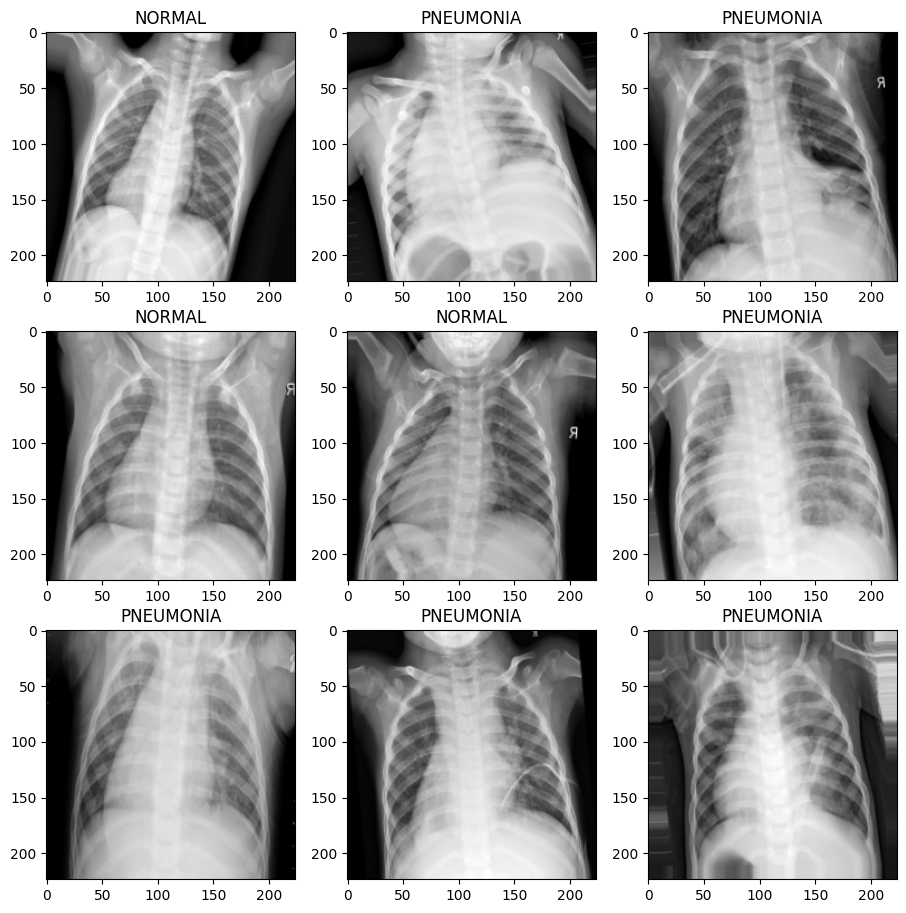

In [32]:
train_loader2, valid_loader2, test_loader2 = build_dataloaders(
    augment_train_data=True)
plot_sample_dataloader_images(train_loader2)

#### Regularization

In simple words, regularization is focused on preventing a model from relying too much on any one of its parameters for making a prediction. To clarify, relying too much on any one parameter means that the value of that parameter gets too large, and therefore, that parameter will play a vital role in changing a model's decision. The intuition behind this theory is that if one or a few parameters have large values within a model, then the model is probably overfitting to those features. For example, suppose we want to train a model to differentiate CXRs for COVID19 patients with good prognosis from CXRs for COVID19 patients with poor prognosis. In that case, a suboptimal model may make predictions based on the presence or absence of a tracheal tube in the image (which is more common in poor prognosis patients but not always a prognosis determining factor) rather than relying on the lung tissue. In such a case, the weights responsible for detecting the features of a tracheal tube within the network may be much larger than other weights. Thus, whenever a tracheal tube is in the image field, the model will likely predict a poor prognosis. In summary, the purpose of regularization is to prevent such weights from getting too large!

There are many regularization techniques available for imaging models, many of which are described [here](https://theaisummer.com/regularization/). For the sake of this notebook, we introduce a basic and easily implemented regularization technique: **the L2 regularization** or **"weight decay"**.

The idea of weight decay is simple: we penalize the weights that are large and force them towards zero (though they never become zero since this penalty declines as it approaches 0):


<br><img src="https://i.ibb.co/CVCsFJn/img15.png" alt="img15" border="0" height="300"><u><br><b>Figure 14.</b> Cross-entropy loss with L2 regularization (weight decay)</u>
</br><br>

As shown above, a new term is added to the loss function, called L2. The higher the model's weights are, the higher the L2 will be, and thus, the overall loss. Here, lambda() is a hyperparameter to tune and determine how much penalty a model should receive from weight decay.

Fortunately, implementing weight decay in PyTorch is very simple. You only need to pass the lambda value to the optimizer class when building your optimizer. Then PyTorch will automatically implement that during the training:

```python
optimizer = torch.optim.SGD(vgg16_model_3.parameters(), lr=learning_rate, weight_decay=0.001)
```

In most cases, start with a value between 0.01 or 0.001 for lambda and gradually try larger or smaller values to find the optimal contribution of L2.

#### Architecture selection

From the discussion above, you can see that the more parameters a model has, the greater the tendency for overfitting. Imagine such a model as a smart but lazy student. It will learn the easiest way to solve the riddle of training data. If that is possible by simply memorizing all the data points you have, it might perform even better without having to learn the underlying principles.

Albert Einstein famously said that things should be made as simple as possible but no simpler (https://www.brainyquote.com/quotes/albert_einstein_103652). This is particularly true for deep learning models. The challenge is knowing what that right size is. The question of how big a model should be is, again, a matter of experimenting. A common strategy is to start with a model that worked well on a 'similar' problem, and if it overfits quickly, then reduce complexity and if it underfits, increase complexity. Repeat until satisfactory results are found. There are some computer-based strategies to automate this that will be discussed at a later time.

Another important point to mention is that smaller models are not 'dumb' nor more challenging to train. Yes, they have lower capacity, but they may perform better than a more complex model! In fact, tons of research in deep learning has been done to build small but smart models. ResNet models (which you should be familiar with from the previous chapters, otherwise, check [here](https://towardsdatascience.com/review-resnet-winner-of-ilsvrc-2015-image-classification-localization-detection-e39402bfa5d8)), inception model (check [here](https://sheng-fang.github.io/2020-05-05-review-googlenet-v1-v4/)), and EfficientNet models (check [here](https://towardsdatascience.com/efficientnet-scaling-of-convolutional-neural-networks-done-right-3fde32aef8ff)) are among the well-known examples of such novel architectural designs. These models will always beat a model like VGG16 in terms of overfitting. You may also design your own architectures to achieve even smaller but smarter models than what is already known.

Fortunately, working with ResNet models in PyTorch is as easy as working with VGG models. Lets' try a ResNet18 model and compare the number of parameters it has with our VGG16:

In [33]:
resnet18_model_1 = build_model(arch='resnet18', pretrained=False).cuda()
summary(resnet18_model_1, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

As you can see, our ResNet 18 has about 11 million parameters, while our VGG16 had about 134 million! This is a huge difference! You will shortly be even more surprised when you see the performance of ResNet18 is also much better than the VGG.

#### Transfer learning and fine-tuning

Last but not least, **transfer learning** is one of the best techniques to reduce overfitting. Not only does it help with a better fit, but it also reduces the dependency of training on training data. This means, with appropriate deployment of transfer learning, the model may learn the same or even better with a smaller fraction of data at hand. This is very useful in fields like medicine when adding more data is not always feasible.

There are many ways to define transfer learning, but consider the analogy introduced at the beginning of this chapter. Remember that each deep learning model is a huge mathematical equation with many parameters. We told you that these parameters often begin with random values when the model is created. In transfer learning, these parameters are not randomly initiated anymore. Instead, they are imported from another model already trained to do a task similar to what we pursue. This source model is called a "pre-trained" model.

Imagine our VGG16 model to classify the CXRs, and suppose we already have access to another VGG16 model that others have trained to differentiate viral pneumonia from COVID19 pneumonia. Although this second model is not exactly doing what we want to do, it is doing something similar, and perhaps, it will use many features that are similar to the features that our model should learn. In mathematical terms, many parameters of our model will probably end up having values close to values of the second model's parameters. Therefore, if one starts with this second model and starts to train that for the new purpose, training will probably be much faster and smoother than when training a randomly-initiated model from scratch. This process of just updating weights rather than training from random values is called **"fine-tuning."**

<br><img src="https://i.ibb.co/ck0tQt6/img16.png" alt="img16" border="0" height="500"><u><br><b>Figure 14.</b> Transfer learning vs. learning from scratch</u><br>Source: https://medium.datadriveninvestor.com/introducing-transfer-learning-as-your-next-engine-to-drive-future-innovations-5e81a15bb567
</br><br>

It is not always possible to find a model that does a 'similar task' but it is often the case that transfer learning from a model that is fairly different can still be better than starting from random values. The good news is that there are a number of pre-trained models (e.g. the ImageNet database) for a variety of purposes that can be very useful for transfer learning, and if you have limited data, it is valuable to start with one of those models.

According to Wikipedia, The ImageNet project is a large visual database designed for use in visual object recognition software research. It consists of more than 14 million images of natural (not medical) objects that have been hand-annotated by the project to indicate what objects are pictured. As a tradition, whenever well-known deep learning models are introduced, developers pre-train them on ImageNet and release their weights. This means in the worst-case scenario, you can find access to the weights of a standard model that has been pre-trained on ImageNet to use in your project (unless you aim to use a custom architecture of your own or others). Although ImageNet is not a medical database, transfer learning from it to medical tasks is better than no transfer learning in many cases. The reason is that the ImageNet database is huge. Therefore, models pre-trained on that will have a memory of many features, at least some of which may be useful for medical training sessions as well.

If you check the script for the "Build-model" function above, you can see that it loaded pre-trained weights from a model pre-trained on ImageNet to our VGG16 model. Do this now and see how an ImageNet pre-trained VGG16 will perform in evaluating our CXRs:

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 192MB/s]


  0%|          | 0/39 [00:00<?, ?it/s]

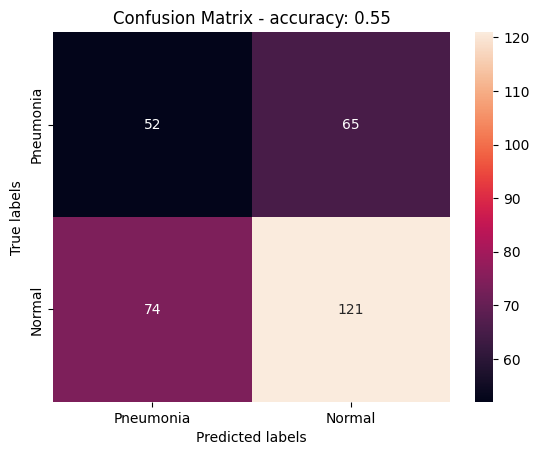

In [34]:
# Evaluating the performance of an ImageNet-pretrained model

Imagenet_pretrained_vgg16 = build_model(arch='vgg16', pretrained=True)
_ = evaluate_model(Imagenet_pretrained_vgg16)

This shows that the pre-trained model was not that successful in differentiating our CXRs from each other, but that should not be a surprise since that was not the ImageNet task. As said before, models pre-trained on ImageNet are trained to identify natural objects like animals, cars, etc. A model pre-trained on ImageNet will probably not do better on a medical imaging task than a randomly-initialized model. If we want to see the value of transfer learning, we must perform fine-tuning.

To emphasize again, fine-tuning means to start with a pre-trained model, freeze 'most' initial layers, and train the remaining layers (by 'freeze' we mean that the weights are not changed). The intuition behind this technique is that the initial layers of the models often learn low-level features (e.g., lines, edges, curves, circles, etc.). Subsequent layers recognize combinations of these (e.g. 2 lines at a 90 degree angle are a corner and 2 circles might represent eyes). As a result, in an ImageNet pre-trained model, we should mostly rely on the first two or three layers. Anything after those layers are likely specific to natural images and, therefore, not helpful in understanding medical images. Of course, if you happen to find a good medical imaging source model for your task, then feel free to use more later layers.


---


> **Note:** This is the most basic form of fine-tuning. More advanced forms also exist, which are beyond the scope of this chapter.


---

To see this in practice, load a ResNet18 model pre-trained on ImageNet, freeze its initial layers, and train it on our data. We will also use L2 regularization and data augmentation to focus resources to avoid overfitting and to improve performance.  

In [35]:
# Defining a function to freeze the resnet models for fine-tunning

def freeze_resnet18(resnet18_model: Callable,
                    children_num_to_freeze: int = 5,
                    print_children: bool = False):
  """
  Freeze a resnet18 model up to a user-specified children module.
  Parameters:
    resnet18_model: The resnet18 model to be frozen and returned.
    children_num_to_freeze: The number of children modules to be frozen.
    print_children (bool): Whether or not to print the children modules.
  """
  for i, child in enumerate(resnet18_model.children()):
    if i < children_num_to_freeze:
      status = 'Frozen'
      for param in child.parameters():
        param.requires_grad = False
    else:
      status = 'Unfrozen'
      for param in child.parameters():
        param.requires_grad = True
    if print_children:
      print(f'******************* child module number: {i} - {status}')
      print(child)
  return resnet18_model

In [36]:
# Creating a resnet18 model and freezing its inital layers.

resnet18_model = build_model(arch='resnet18', pretrained=True)
resnet18_model = freeze_resnet18(resnet18_model,
                                   children_num_to_freeze = 5,
                                   print_children=False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


-------------------- 
Starting epoch: 1/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.13 |     train accuracy: 0.95
valid loss: 0.80 |     valid accuracy: 0.79
-------------------- 
Starting epoch: 2/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.08 |     train accuracy: 0.97
valid loss: 0.70 |     valid accuracy: 0.84
-------------------- 
Starting epoch: 3/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.04 |     train accuracy: 0.99
valid loss: 0.83 |     valid accuracy: 0.84
-------------------- 
Starting epoch: 4/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.04 |     train accuracy: 0.99
valid loss: 1.14 |     valid accuracy: 0.76
-------------------- 
Starting epoch: 5/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.02 |     train accuracy: 0.99
valid loss: 1.49 |     valid accuracy: 0.76
-------------------- 
Starting epoch: 6/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.01 |     train accuracy: 1.00
valid loss: 1.17 |     valid accuracy: 0.80
-------------------- 
Starting epoch: 7/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.02 |     train accuracy: 1.00
valid loss: 1.53 |     valid accuracy: 0.78
-------------------- 
Starting epoch: 8/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.01 |     train accuracy: 1.00
valid loss: 1.61 |     valid accuracy: 0.75
-------------------- 
Starting epoch: 9/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.01 |     train accuracy: 1.00
valid loss: 1.22 |     valid accuracy: 0.82
-------------------- 
Starting epoch: 10/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.01 |     train accuracy: 1.00
valid loss: 1.20 |     valid accuracy: 0.84

Trainng was over. The best model was: resnet18_model_2_Epoch2_ACC=0.8397435897435898.pth


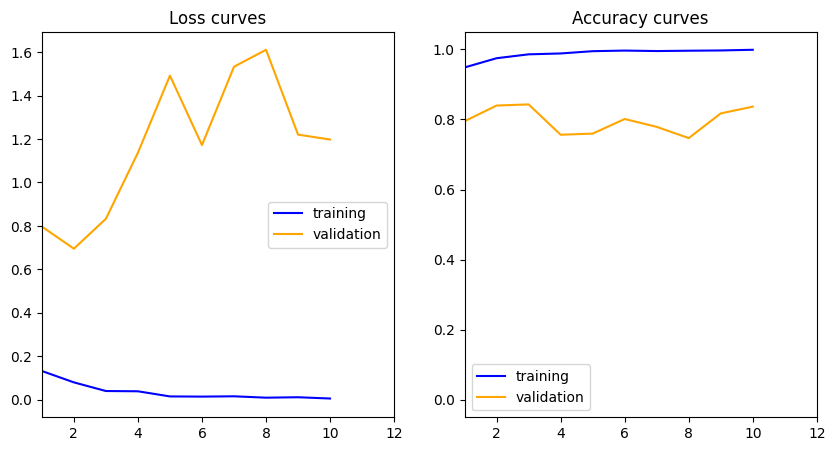

In [37]:
# Training a model with resnet18 architecture and pretrained weights

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=learning_rate,
                            weight_decay=0.001)
num_epochs = 10
resnet18_model_2 = train_classifier(model=resnet18_model,
                                 model_name='resnet18_model_2',
                                 train_loader=train_loader2,
                                 valid_loader=valid_loader2,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 num_epochs=num_epochs,
                                 plot_curves=True)

  0%|          | 0/39 [00:00<?, ?it/s]

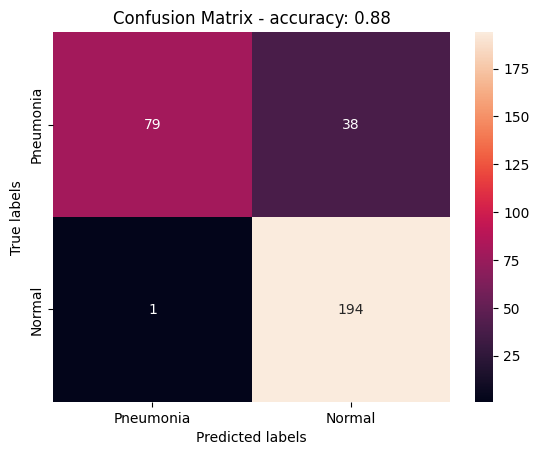

In [38]:
# Evaluating the performance of resnet18_model_2 on the test set

_ = evaluate_model(resnet18_model)

You should see a dramatic jump in performance. This is why you should always be familiar with as many deep learning techniques and tricks as possible. Now that we have reviewed the most common techniques to battle overfitting, our discussion in this chapter is almost over. Feel free to review the above concepts and redo the training in different variations. Try to include or exclude different techniques we introduced to see how much each will affect the model's performance. Do not forget: Deep learning is, of course, a matter of science and art, but it also is a matter of experimenting and having perseverance!

## Part 6: Conclusions and further reading

This chapter described how to train a deep learning model. This included a discussion of how a neural network resembles a mathematical equation. That was followed by a definition of training and how to implement that in PyTorch. Next, the concepts of fit and how to combat under-fitting and over-fitting were covered. The discussion was enriched with many practical examples and Python code.
Nevertheless, this is still only a tiny fraction of the world of deep learning. Other resources that may be useful to understand the concepts include:

*   [A Beginner Intro to Neural Networks](https://purnasaigudikandula.medium.com/a-beginner-intro-to-neural-networks-543267bda3c8)
*   [How to train neural networks for image classification — Part 1](https://medium.com/nerd-for-tech/how-to-train-neural-networks-for-image-classification-part-1-21327fe1cc1)
*   [FastAI course - SGD from scratch](https://course.fast.ai/videos/?lesson=4)
*   [Anrew Ng's deep learning specialization on Coursera, courses 1 and 2](https://www.coursera.org/specializations/deep-learning)



---

##***Feedback***

*Now that you have completed this chapter, we would be very grateful if you spend a few minutes of your time to answer a short survey about this chapter. We highly value your feedback and will do our best to leverage this to improve our educational content and/or strategies.*

[Click here to begin the survey!](https://docs.google.com/forms/d/e/1FAIpQLSddhdaAmeHmrKKRNXCLIQH6_mnIC3KR7XlDIVWGt3FSQhPDhQ/viewform)